In [226]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil 
from matplotlib.colors import LinearSegmentedColormap
import datetime
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

pd.set_option("display.max_columns", None)

In [157]:
random_state = 123
# outlier_limit = 99.5
sns.set()
sns.set_context("paper")
sns.set(style="white")

plt.rcParams['figure.dpi'] = 98

colors = ['#646E78','#d1d646', '#97bf78', '#7ca282', '#61858c', '#466796', '#8967b5', '#b363b9', '#d560bc', '#f25dbf']

show_plots = True
save_plots = False
img_counter = 0
kaggle = False
div_colors = ['#466796','#9ca9c3','#f1f1f1','#e5e39f','#d1d646']
div_cmap = LinearSegmentedColormap.from_list("mycmap", div_colors)

# def transform_dataypes(df, has_y=True) :
#     df['Date'] = pd.to_datetime(df['Date'])
#     df['Browser'] = df['Browser'].astype('str')
#     df['Type_of_Traffic'] = df['Type_of_Traffic'].astype('str')
#     if has_y == True:
#         df['Buy'] = df['Buy'].astype('bool')

#     return df

def log_transform_data(df, col):
    return np.log1p(df[col])

## Function to plot histograms of numeric features for specified dataframe
def plotHistograms(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if show_plots:
        fig, axes = plt.subplots(rows, ceil(len(features) / rows), \
                             figsize=(11, 3*rows), constrained_layout=True, sharey=True)
        
        for ax, feat in zip(axes.flatten(), features):
            ax.set_title(feat, y=1)
            ax.legend()
            df.pivot(columns='Buy')[feat].plot(kind = 'hist', stacked=True, ax=ax, color=colors[0:2])
    
        if (len(axes.flatten())) > len(features):
            for f in range(len(axes.flatten())-len(features)):
                axes.flatten()[(f+1)*-1].axis('off')
        plt.suptitle(title)
        plt.show()
    else:
        print("show_plots is currently set to False")

## Function to plot histograms of numeric features for specified dataframe
def plot_histograms_boxplots(df, features, rows=4, title = "Histograms of Numeric Variables"):
    if show_plots:
        fig = plt.figure(figsize=(11, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows))
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios': [4, 1,1]})
        
            df.pivot(columns='IsCanceled')[feat].plot(kind = 'hist', stacked=True, ax=axs[0], color=colors[0:2])
            axs[0].set_ylabel(None)
            axs[0].set_title(feat, y=1)
        
            sns.boxplot(x=df.loc[df['IsCanceled']==0,feat], ax=axs[1], color=colors[0], fliersize=2)
            axs[1].set_xlabel(None)
        
            sns.boxplot(x=df.loc[df['IsCanceled']==1,feat], ax=axs[2], color=colors[1], fliersize=2)
            axs[2].set_xlabel(None)
        
            subf.suptitle(None)

        plt.suptitle(title)
        plt.show()
        if save_plots:
            save_fig(title, fig)
    else:
        print("show_plots is currently set to False")



def make_corr_heatmap(d_X, d_y, method, title="Triangle Correlation Heatmap"):
    if show_plots:
        fig, ax = plt.subplots(figsize=(13, 7))
    
        map_corr = np.round(d_X.join(d_y).corr(method=method),decimals=2)
    
        mask_annot = np.absolute(map_corr.values) >= 0.65
        annot = np.where(mask_annot, map_corr.values, np.full(map_corr.shape,"")) # Try to understand what this np.where() does
        mask = np.triu(np.ones_like(map_corr, dtype=bool))
    
        heatmap = sns.heatmap(map_corr, mask=mask, vmin=-1, vmax=1, annot=annot, cmap=div_cmap, fmt='')
        heatmap.set_title(title, fontdict={'fontsize':18}, pad=16);
        if save_plots:
            save_fig(title, fig)
    else:
        print("show_plots is currently set to False")



def save_fig(title, fig, dest='img/', img_counter=img_counter):
    img_counter = img_counter + 1
    fn = dest + str(img_counter) + '_' + title.replace(' ','-') + '.png'
    fig.savefig(fn, bbox_inches='tight')
    
def plot_cat_counts(df, features, rows=6, title = "Count Distributions of Categorical Variables"):
    if show_plots:
        fig = plt.figure(figsize=(2.85*rows, 4*rows), constrained_layout=True)
        subfigs = fig.subfigures(rows, ceil(len(features) / rows), wspace=0.07, hspace=0.1)
    
        for subf, feat in zip(subfigs.flatten(), features):
            axs = subf.subplots(1, 2, sharey=True) #, gridspec_kw={'width_ratios': [4, 1,1]})
 
            df1 = df.groupby([feat,'IsCanceled']).size().unstack(1)\
                .plot(kind="barh", stacked=True, ax=axs[0], color=colors)

            df2 = df.groupby([feat,'IsCanceled']).size().unstack(1)
            df2.div(df2.sum(axis=1), axis=0)\
                .plot(kind="barh", stacked=True, ax=axs[1], color=colors)
            
            subf.suptitle(feat)
            

        plt.suptitle(title)
        plt.show()
        if save_plots:
            save_fig(title, fig)

    else:
        print("show_plots is currently set to False")

In [158]:
# data_train_num = data_train.select_dtypes(include=np.number).set_index(data_train.index)
# data_train_cat = data_train.select_dtypes(exclude=np.number).set_index(data_train.index).drop("Buy", axis = 1)
# num_feat = data_train_num.columns.tolist()
# cat_feat = data_train_cat.columns.tolist()

# data_test_num = data_test.select_dtypes(include=np.number).set_index(data_test.index)
# data_test_cat = data_test.select_dtypes(exclude=np.number).set_index(data_test.index)

In [159]:
# original_cat_feats = data_train.select_dtypes(exclude=np.number).columns.tolist()

# plot_cat_counts(data_train, original_cat_feats)

In [160]:
# plot_histograms_boxplots(data_train, num_feat, rows=4)

## IMPORT AND EXPLORATION

In [161]:
data = pd.read_csv("H2.csv")
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 31 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   IsCanceled                   79330 non-null  int64  
 1   LeadTime                     79330 non-null  int64  
 2   ArrivalDateYear              79330 non-null  int64  
 3   ArrivalDateMonth             79330 non-null  object 
 4   ArrivalDateWeekNumber        79330 non-null  int64  
 5   ArrivalDateDayOfMonth        79330 non-null  int64  
 6   StaysInWeekendNights         79330 non-null  int64  
 7   StaysInWeekNights            79330 non-null  int64  
 8   Adults                       79330 non-null  int64  
 9   Children                     79326 non-null  float64
 10  Babies                       79330 non-null  int64  
 11  Meal                         79330 non-null  object 
 12  Country                      79306 non-null  object 
 13  MarketSegment   

In [163]:
data["DurationOfStay"] = data["StaysInWeekNights"] + data["StaysInWeekendNights"]
data["TotalValue"] = data["DurationOfStay"] * data["ADR"]
data["ArrivalDateMonthNumber"] = data["ArrivalDateMonth"].apply(lambda x : datetime.datetime.strptime(x, "%B").month).astype("str")
data["ArrivalDate"] = data["ArrivalDateYear"].astype(str) + "-" + data["ArrivalDateMonthNumber"].astype(str) + "-" + data["ArrivalDateDayOfMonth"].astype(str)
data["ArrivalDate"] = pd.to_datetime(data["ArrivalDate"])
data['ArrivalDayOfWeek'] = data['ArrivalDate'].dt.dayofweek.astype('str')
data.drop("ArrivalDateMonth", inplace = True, axis = 1)
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek
0,0,6,2015,27,1,0,2,1,0.0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03,2,0.00,7,2015-07-01,2
1,1,88,2015,27,1,0,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01,4,306.00,7,2015-07-01,2
2,1,65,2015,27,1,0,4,1,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30,4,272.00,7,2015-07-01,2
3,1,92,2015,27,1,2,4,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23,6,459.00,7,2015-07-01,2
4,1,100,2015,27,2,0,2,2,0.0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02,2,153.00,7,2015-07-02,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,7,672.98,8,2017-08-30,2
79326,0,102,2017,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,7,1578.01,8,2017-08-31,3
79327,0,34,2017,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,7,1103.97,8,2017-08-31,3
79328,0,109,2017,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,7,730.80,8,2017-08-31,3


In [164]:
data["ReservationStatusDate"] = pd.to_datetime(data["ReservationStatusDate"])

data['ReservationDayOfMonth'] = data['ReservationStatusDate'].dt.day.astype('str')
data['ReservationWeekOfYear'] = data['ReservationStatusDate'].dt.weekofyear.astype('str')
data['ReservationMonth'] = data['ReservationStatusDate'].dt.month.astype('str')
data['ReservationDayOfWeek'] = data['ReservationStatusDate'].dt.dayofweek.astype('str')

In [202]:
data["IsRoomChanged"] = (data["AssignedRoomType"] != data["ReservedRoomType"])

In [203]:
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,IsRoomChanged
0,0,6,2015,27,1,0,2,1,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03,2,0.00,7,2015-07-01,2,3,27,7,4,False
1,1,88,2015,27,1,0,4,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01,4,306.00,7,2015-07-01,2,1,27,7,2,False
2,1,65,2015,27,1,0,4,1,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30,4,272.00,7,2015-07-01,2,30,18,4,3,False
3,1,92,2015,27,1,2,4,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23,6,459.00,7,2015-07-01,2,23,26,6,1,False
4,1,100,2015,27,2,0,2,2,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02,2,153.00,7,2015-07-02,3,2,14,4,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06,7,672.98,8,2017-08-30,2,6,36,9,2,False
79326,0,102,2017,35,31,2,5,3,0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07,7,1578.01,8,2017-08-31,3,7,36,9,3,False
79327,0,34,2017,35,31,2,5,2,0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07,7,1103.97,8,2017-08-31,3,7,36,9,3,False
79328,0,109,2017,35,31,2,5,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07,7,730.80,8,2017-08-31,3,7,36,9,3,False


In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79330 entries, 0 to 79329
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   IsCanceled                   79330 non-null  int64         
 1   LeadTime                     79330 non-null  int64         
 2   ArrivalDateYear              79330 non-null  int64         
 3   ArrivalDateWeekNumber        79330 non-null  int64         
 4   ArrivalDateDayOfMonth        79330 non-null  int64         
 5   StaysInWeekendNights         79330 non-null  int64         
 6   StaysInWeekNights            79330 non-null  int64         
 7   Adults                       79330 non-null  int64         
 8   Children                     79326 non-null  float64       
 9   Babies                       79330 non-null  int64         
 10  Meal                         79330 non-null  object        
 11  Country                      79306 non-nu

In [167]:
numeric_features = data.select_dtypes(include=np.number).set_index(data.index).columns.tolist()
data[numeric_features]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,BookingChanges,DaysInWaitingList,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,DurationOfStay,TotalValue
0,0,6,2015,27,1,0,2,1,0.0,0,0,0,0,0,0,0.00,0,0,2,0.00
1,1,88,2015,27,1,0,4,2,0.0,0,0,0,0,0,0,76.50,0,1,4,306.00
2,1,65,2015,27,1,0,4,1,0.0,0,0,0,0,0,0,68.00,0,1,4,272.00
3,1,92,2015,27,1,2,4,2,0.0,0,0,0,0,0,0,76.50,0,2,6,459.00
4,1,100,2015,27,2,0,2,2,0.0,0,0,0,0,0,0,76.50,0,1,2,153.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,35,30,2,5,2,0.0,0,0,0,0,0,0,96.14,0,0,7,672.98
79326,0,102,2017,35,31,2,5,3,0.0,0,0,0,0,0,0,225.43,0,2,7,1578.01
79327,0,34,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,157.71,0,4,7,1103.97
79328,0,109,2017,35,31,2,5,2,0.0,0,0,0,0,0,0,104.40,0,0,7,730.80


In [168]:
to_discard = ["ArrivalDateYear", "ArrivalDateDayOfMonth", "IsRepeatedGuest", "IsCanceled"]
# metric_features = numeric_features.remove(feat for feat in to_discard)
metric_features = numeric_features.copy()
for feat in to_discard:
    metric_features.remove(feat)
metric_features

['LeadTime',
 'ArrivalDateWeekNumber',
 'StaysInWeekendNights',
 'StaysInWeekNights',
 'Adults',
 'Children',
 'Babies',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'BookingChanges',
 'DaysInWaitingList',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'DurationOfStay',
 'TotalValue']

In [169]:
categorical_features = data.select_dtypes(exclude=np.number).set_index(data.index).columns.tolist()
categorical_features.extend(to_discard)
data[categorical_features]

,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,Agent,Company,CustomerType,ReservationStatus,ReservationStatusDate,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek,ArrivalDateYear,ArrivalDateDayOfMonth,IsRepeatedGuest,IsCanceled
0,HB,PRT,Offline TA/TO,TA/TO,A,A,No Deposit,6,NULL,Transient,Check-Out,2015-07-03,7,2015-07-01,2,3,27,7,4,2015,1,0,0
1,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-07-01,7,2015-07-01,2,1,27,7,2,2015,1,0,1
2,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-04-30,7,2015-07-01,2,30,18,4,3,2015,1,0,1
3,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-06-23,7,2015-07-01,2,23,26,6,1,2015,1,0,1
4,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Canceled,2015-04-02,7,2015-07-02,3,2,14,4,3,2015,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,BB,BEL,Offline TA/TO,TA/TO,A,A,No Deposit,394,NULL,Transient,Check-Out,2017-09-06,8,2017-08-30,2,6,36,9,2,2017,30,0,0
79326,BB,FRA,Online TA,TA/TO,E,E,No Deposit,9,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,2017,31,0,0
79327,BB,DEU,Online TA,TA/TO,D,D,No Deposit,9,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,2017,31,0,0
79328,BB,GBR,Online TA,TA/TO,A,A,No Deposit,89,NULL,Transient,Check-Out,2017-09-07,8,2017-08-31,3,7,36,9,3,2017,31,0,0


In [170]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
IsCanceled,79330.0,0.417270,0.493111,0.0,0.0,0.0,1.0,1.0
LeadTime,79330.0,109.735724,110.948526,0.0,23.0,74.0,163.0,629.0
ArrivalDateYear,79330.0,2016.174285,0.699181,2015.0,2016.0,2016.0,2017.0,2017.0
ArrivalDateWeekNumber,79330.0,27.177449,13.398523,1.0,17.0,27.0,38.0,53.0
ArrivalDateDayOfMonth,79330.0,15.786625,8.728451,1.0,8.0,16.0,23.0,31.0
StaysInWeekendNights,79330.0,0.795185,0.885026,0.0,0.0,1.0,2.0,16.0
StaysInWeekNights,79330.0,2.182957,1.456416,0.0,1.0,2.0,3.0,41.0
Adults,79330.0,1.850977,0.509292,0.0,2.0,2.0,2.0,4.0
Children,79326.0,0.091370,0.372177,0.0,0.0,0.0,0.0,3.0
Babies,79330.0,0.004941,0.084323,0.0,0.0,0.0,0.0,10.0


In [171]:
"Percentage of suspect duplicated data: ", (data.duplicated().sum() / len(data)) * 100

('Percentage of suspect duplicated data: ', 32.65095172066053)

In [172]:
duplicates = data.loc[data.duplicated()]
duplicates = duplicates.groupby(duplicates.columns.tolist(),as_index=False).size().sort_values("size", ascending = False)
size = duplicates.pop("size")
duplicates.insert(0, "size", size)
duplicates

,size,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek
5405,179,1,277,2016,46,7,1,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,NULL,NULL,0,Transient,100.00,0,0,Canceled,2016-04-04,3,300.00,11,2016-11-07,0,4,14,4,0
4180,149,1,68,2016,8,17,0,2,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,37,NULL,0,Transient,75.00,0,0,Canceled,2016-01-06,2,150.00,2,2016-02-17,2,6,1,1,2
5073,108,1,188,2016,25,15,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,Non Refund,119,NULL,39,Transient,130.00,0,0,Canceled,2016-01-18,2,260.00,6,2016-06-15,2,18,3,1,0
4878,100,1,158,2016,22,24,0,2,1,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,37,NULL,31,Transient,130.00,0,0,Canceled,2016-01-18,2,260.00,5,2016-05-24,1,18,3,1,0
3851,99,1,34,2015,50,8,0,2,1,0.0,0,BB,PRT,Offline TA/TO,TA/TO,0,1,0,A,A,0,Non Refund,19,NULL,0,Transient,90.00,0,0,Canceled,2015-11-17,2,180.00,12,2015-12-08,1,17,47,11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481,1,0,59,2017,17,26,0,1,2,0.0,0,BB,CHE,Direct,Direct,0,0,0,D,D,0,No Deposit,14,NULL,0,Transient,130.50,0,2,Check-Out,2017-04-27,1,130.50,4,2017-04-26,2,27,17,4,3
1480,1,0,59,2017,14,6,0,3,2,0.0,0,BB,ISR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,117.00,0,2,Check-Out,2017-04-09,3,351.00,4,2017-04-06,3,9,14,4,6
1479,1,0,59,2017,12,23,0,1,2,0.0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,79.20,0,0,Check-Out,2017-03-24,1,79.20,3,2017-03-23,3,24,12,3,4
3383,1,0,409,2017,22,31,0,3,2,0.0,0,BB,AUS,Groups,TA/TO,0,0,0,A,A,0,No Deposit,229,NULL,0,Transient-Party,112.67,0,2,Check-Out,2017-06-03,3,338.01,5,2017-05-31,2,3,22,6,5


In [173]:
#Exploring the day with most populated duplicates
data.loc[(data.ArrivalDateDayOfMonth == 7) & 
(data.ArrivalDateMonthNumber == 11) & 
(data.ArrivalDateYear == 2016) & 
(data.MarketSegment == "Groups")
].value_counts("LeadTime")

Series([], dtype: int64)

In [174]:
data.loc[(data.ArrivalDateDayOfMonth == 7) & 
(data.ArrivalDateMonthNumber == 11) & 
(data.ArrivalDateYear == 2016) & 
(data.MarketSegment == "Groups")
].value_counts("Agent")

Series([], dtype: int64)

In [175]:
data.loc[(data.ArrivalDateDayOfMonth == 7) & 
(data.ArrivalDateMonthNumber == 11) & 
(data.ArrivalDateYear == 2016)
].value_counts("MarketSegment")

Series([], dtype: int64)

In [176]:
data.loc[data.duplicated()].sort_values("ArrivalDateDayOfMonth")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek
23073,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2
23105,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2
23104,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2
23103,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2
23102,1,56,2017,5,1,0,3,2,0.0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,Non Refund,29,NULL,0,Transient,60.00,0,0,Canceled,2016-12-07,3,180.0,2,2017-02-01,2,7,49,12,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36391,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3
36390,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3
36389,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3
36387,1,379,2015,44,31,1,1,2,0.0,0,BB,PRT,Groups,TA/TO,0,1,0,A,A,0,Non Refund,1,NULL,0,Transient,62.00,0,0,Canceled,2015-07-23,2,124.0,10,2015-10-31,5,23,30,7,3


In [177]:
data.isna().sum(axis = 0).loc[data.isna().sum(axis = 0) > 0]

Children     4
Country     24
dtype: int64

In [178]:
data["Children"].value_counts()

0.0    74220
1.0     3023
2.0     2024
3.0       59
Name: Children, dtype: int64

In [179]:
data["Country"].value_counts()

PRT    30960
FRA     8804
DEU     6084
GBR     5315
ESP     4611
       ...  
MMR        1
UMI        1
NIC        1
VGB        1
COM        1
Name: Country, Length: 166, dtype: int64

In [180]:
# Replacing NaN values with the mode 

data["Children"].replace(np.nan, data["Children"].mode()[0], inplace = True)
data["Country"].replace(np.nan, data["Country"].mode()[0], inplace = True)

data.loc[(data["Children"].isna() == True) | (data["Country"].isna() == True)]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek


In [181]:
data["Children"] = data["Children"].astype("int")

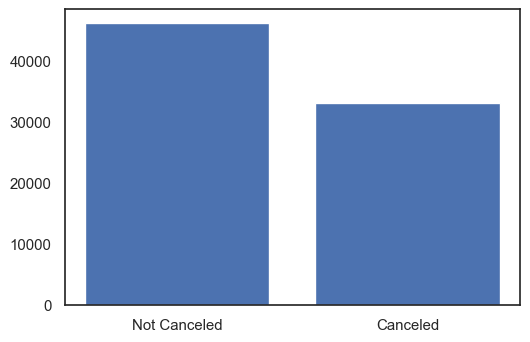

In [182]:
sns.set(style = "white")
plt.bar(height=data["IsCanceled"].value_counts(), x = ["Not Canceled", "Canceled"])
plt.show()

In [183]:
def pairwise_relation(data, features = data.select_dtypes(include=np.number).set_index(data.index).columns,
 title = "Pairwise Relationship of Metric Variables", target = "IsCanceled"):
    
    # Pairwise Relationship of Numerical Variables
    sns.set(style='white')

    # Setting pairplot
    sns.pairplot(data[features], diag_kind="hist", hue=target)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title)

    plt.show()

In [184]:
#around 35 minutes or run time

# pairwise_relationship(data)

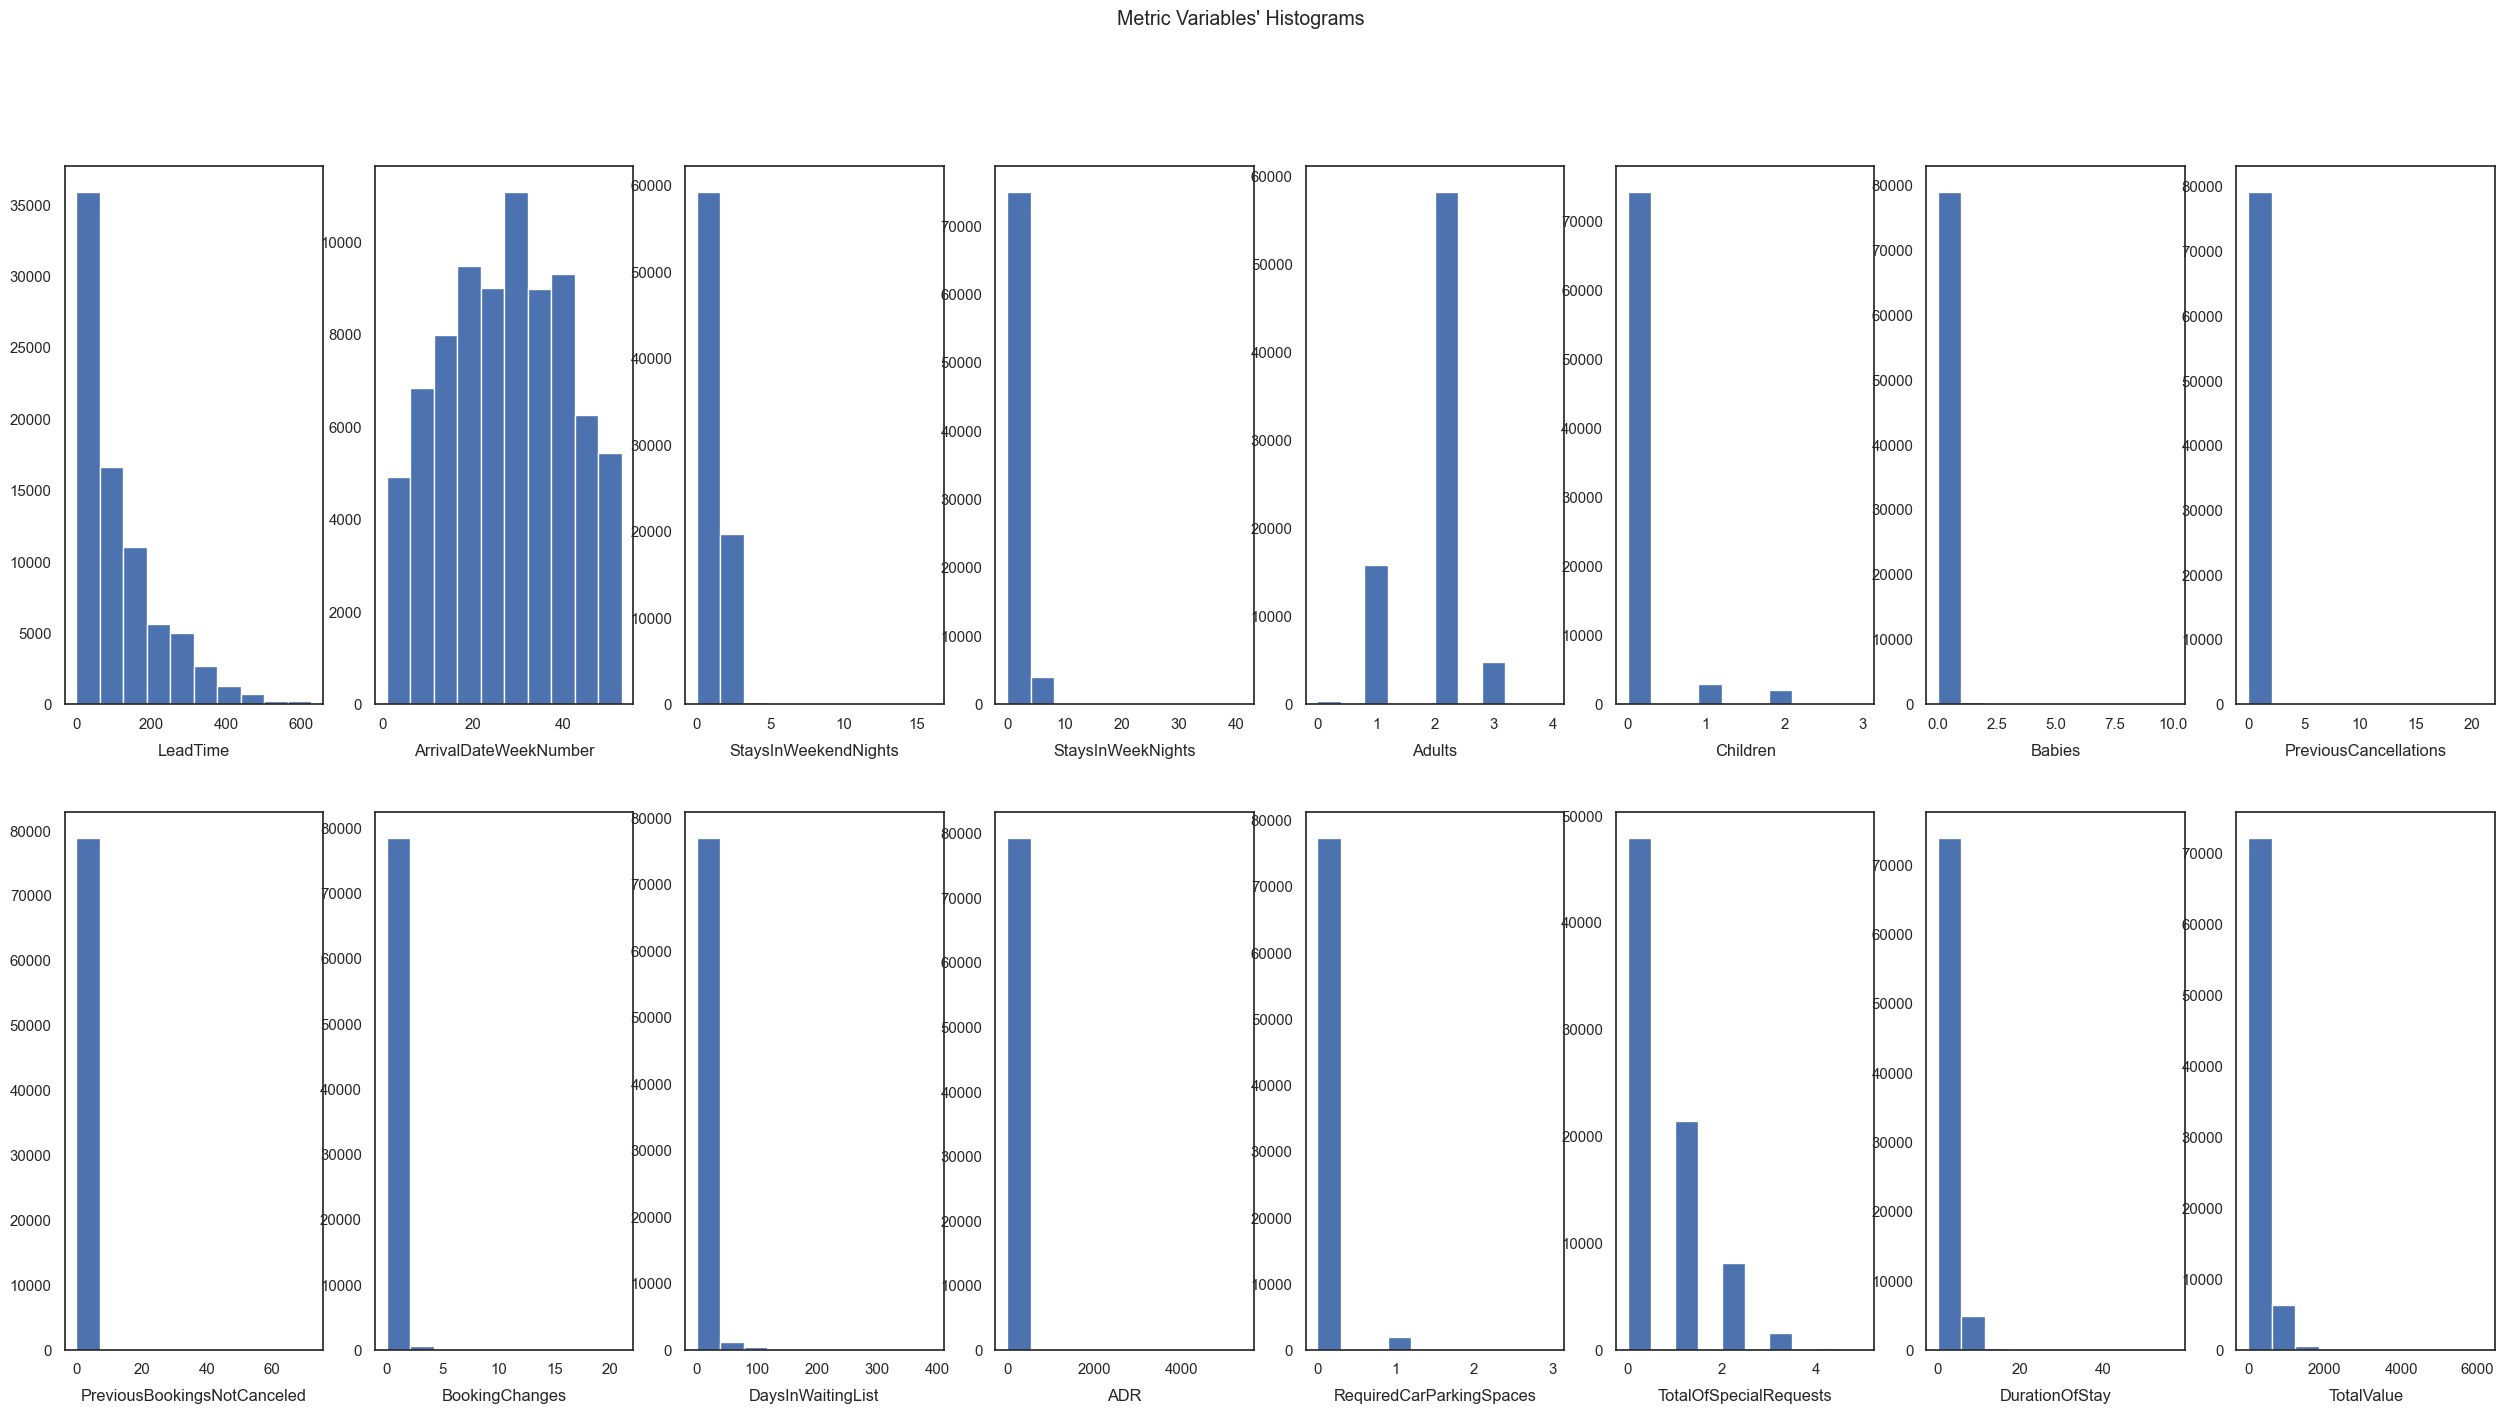

In [185]:
sns.set(style='white')

fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(32, 16))

for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(data[feat])
    ax.set_title(feat, y=-0.11)
    
title = "Metric Variables' Histograms"
plt.suptitle(title)
plt.show()

In [186]:
data.sort_values("StaysInWeekNights", ascending=False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek
61734,0,140,2016,39,22,16,41,0,0,0,SC,GBR,Online TA,TA/TO,0,0,0,A,K,12,No Deposit,9,NULL,0,Transient,8.34,0,2,Check-Out,2016-11-18,57,475.38,9,2016-09-22,3,18,46,11,4
47957,0,16,2016,11,11,14,35,0,0,0,BB,PRT,Corporate,TA/TO,0,0,0,A,K,21,No Deposit,NULL,215,0,Transient-Party,0.00,0,0,Check-Out,2016-04-29,49,0.00,3,2016-03-11,4,29,17,4,4
14644,0,206,2016,30,23,14,34,2,0,0,SC,PRT,Online TA,TA/TO,0,0,0,A,K,6,No Deposit,9,NULL,0,Transient-Party,0.00,0,1,Check-Out,2016-09-09,48,0.00,7,2016-07-23,5,9,36,9,4
66501,0,11,2017,3,15,13,30,0,0,0,SC,USA,Online TA,TA/TO,0,0,0,A,K,14,No Deposit,9,NULL,0,Transient,0.00,0,0,Check-Out,2017-02-27,43,0.00,1,2017-01-15,6,27,9,2,0
63222,0,3,2016,47,14,9,25,2,0,0,BB,PRT,Corporate,Corporate,0,0,0,A,A,3,No Deposit,NULL,368,0,Transient,93.00,0,0,Check-Out,2016-12-18,34,3162.00,11,2016-11-14,0,18,50,12,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61073,0,42,2016,46,7,0,0,1,0,0,BB,PRT,Online TA,TA/TO,0,0,0,A,A,2,No Deposit,10,NULL,0,Transient,0.00,0,0,Check-Out,2016-11-07,0,0.00,11,2016-11-07,0,7,45,11,0
74237,0,20,2017,25,19,1,0,1,0,0,BB,DZA,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,85,NULL,0,Transient,94.00,0,0,Check-Out,2017-06-20,1,94.00,6,2017-06-19,0,20,25,6,1
74236,0,21,2017,25,19,1,0,2,0,0,BB,GBR,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9,NULL,0,Transient,150.00,0,1,Check-Out,2017-06-20,1,150.00,6,2017-06-19,0,20,25,6,1
74234,0,3,2017,25,19,1,0,2,0,0,BB,DEU,Direct,Direct,0,0,0,A,D,1,No Deposit,NULL,NULL,0,Transient,160.00,0,0,Check-Out,2017-06-20,1,160.00,6,2017-06-19,0,20,25,6,1


In [187]:
def boxplot (data, features = data.select_dtypes(include=np.number).set_index(data.index).columns):
    
    
    sns.set(style = 'white')
    fig, axes = plt.subplots(2, ceil(len(features) / 2), figsize=(20, 16))
    
    for ax, feat in zip(axes.flatten(), features): 

        sns.boxplot(data[feat], ax = ax)
        
    title = "Metric Variables' Boxplots"

    plt.suptitle(title)

    plt.show()

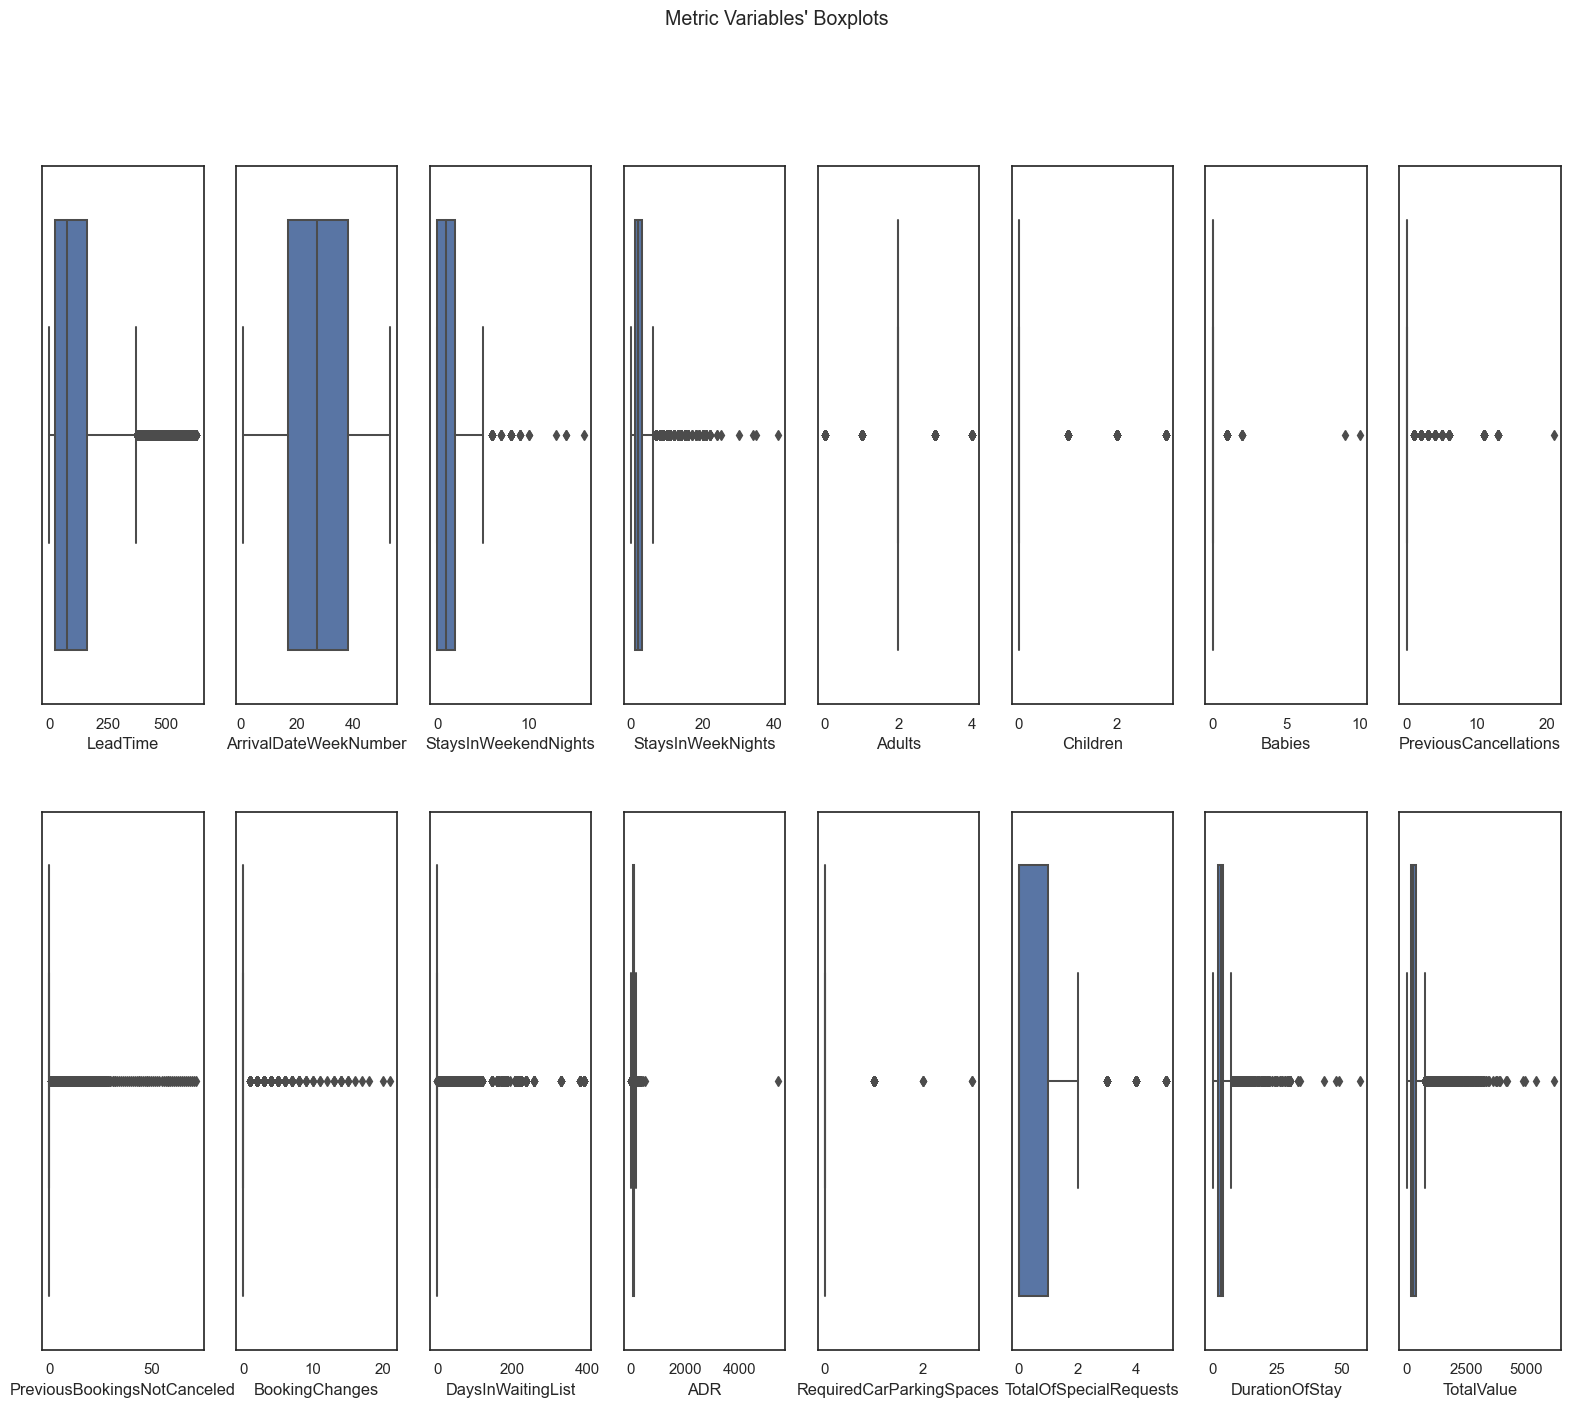

In [188]:
boxplot(data, metric_features)

In [189]:
to_discard

['ArrivalDateYear', 'ArrivalDateDayOfMonth', 'IsRepeatedGuest', 'IsCanceled']

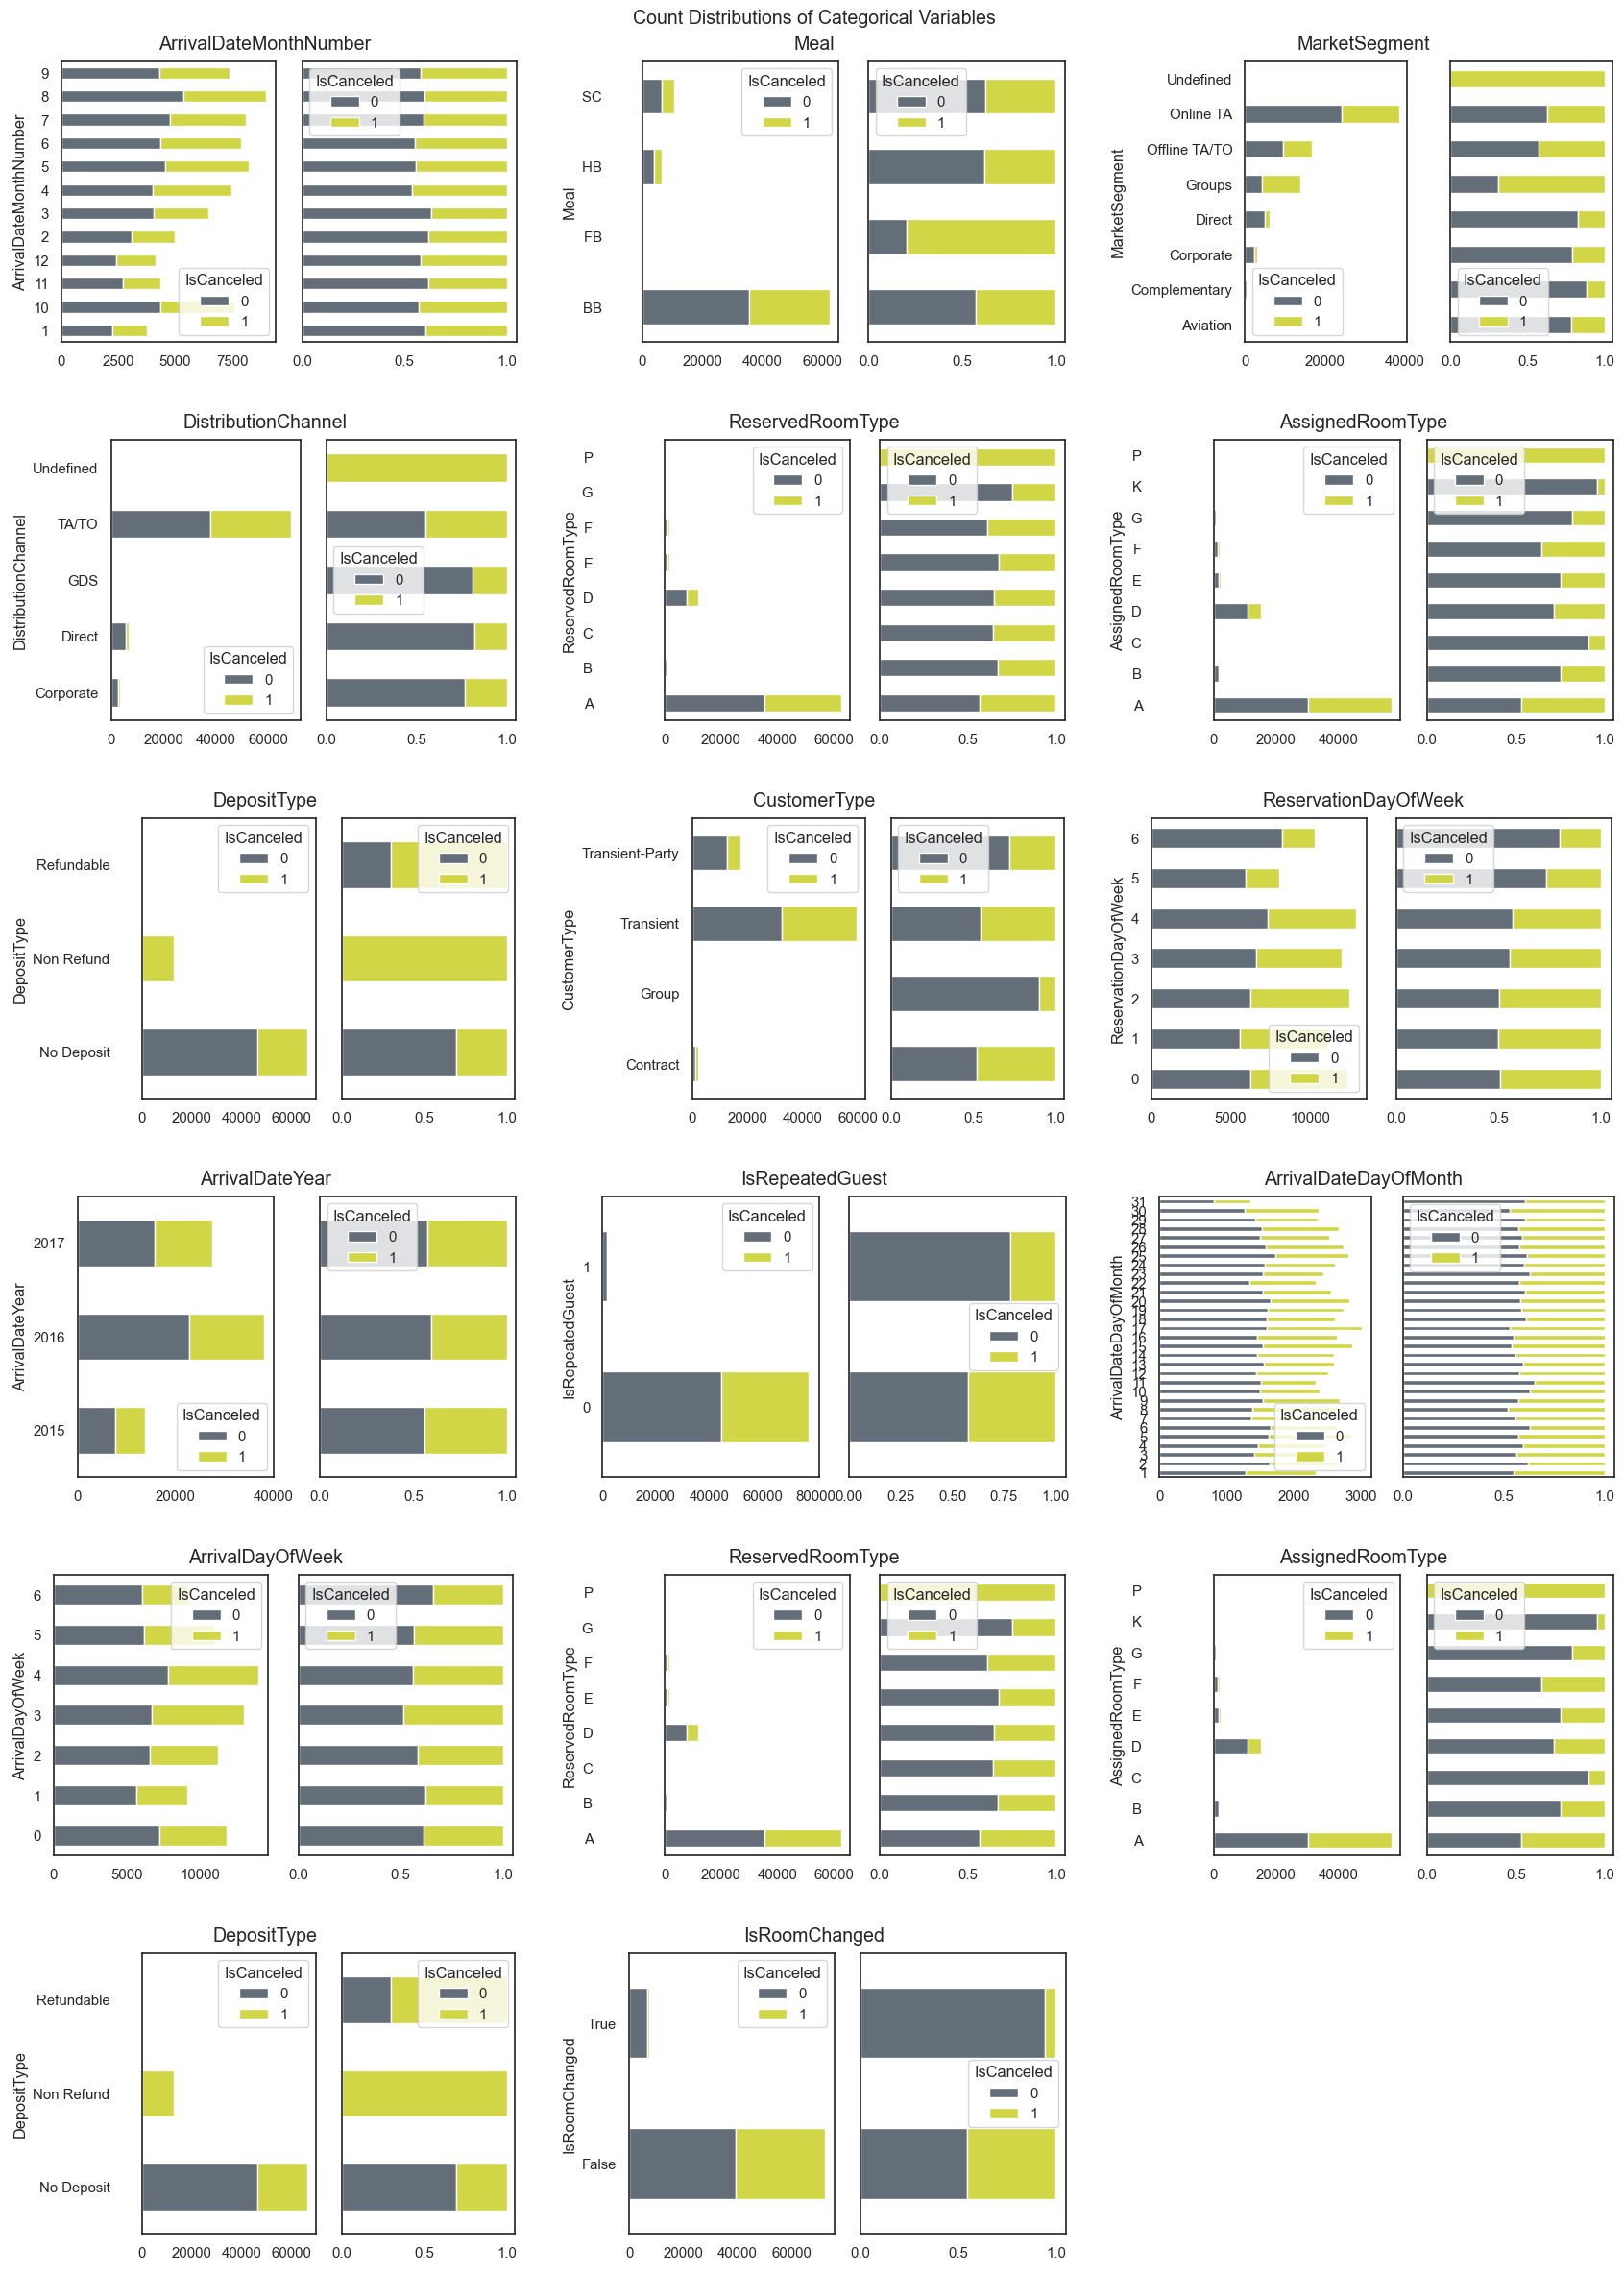

In [204]:
to_plot = ['ArrivalDateMonthNumber', 'Meal','MarketSegment','DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
'DepositType', 'CustomerType', 'ReservationDayOfWeek', 'ArrivalDateYear', 'IsRepeatedGuest', 'ArrivalDateDayOfMonth', "ArrivalDayOfWeek",
"ReservedRoomType", "AssignedRoomType", "DepositType", "IsRoomChanged"]

plot_cat_counts(data, to_plot)

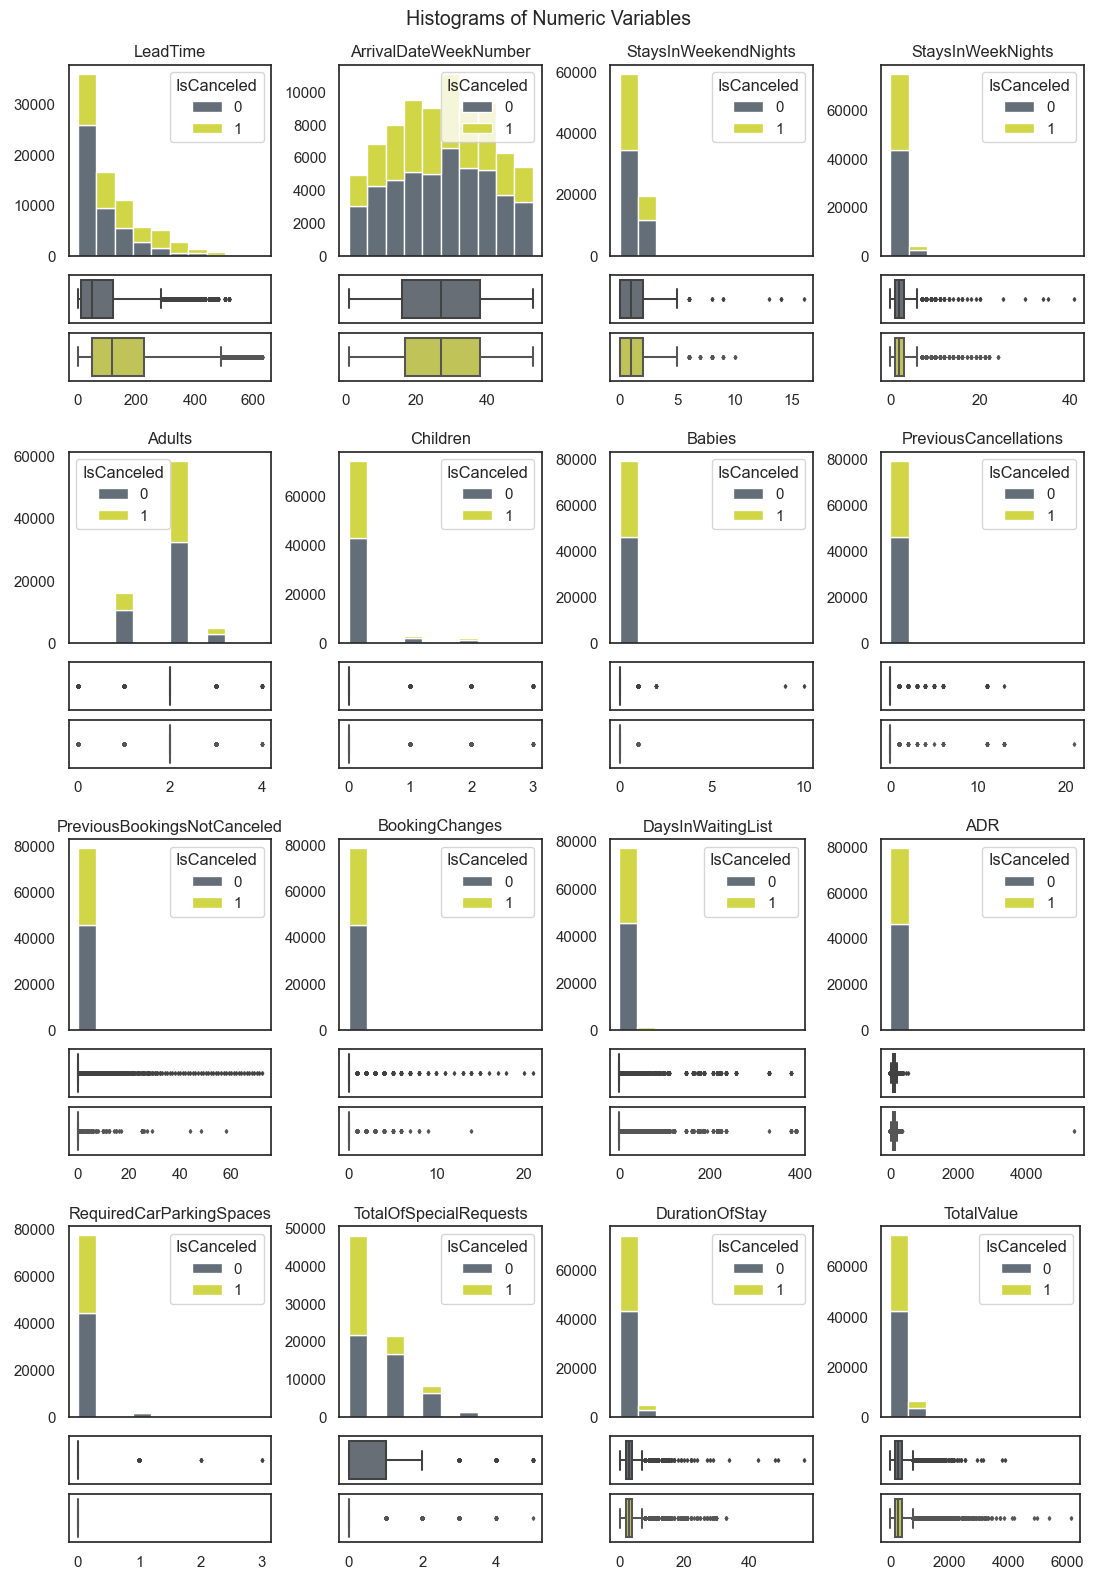

In [197]:
plot_histograms_boxplots(data, metric_features)

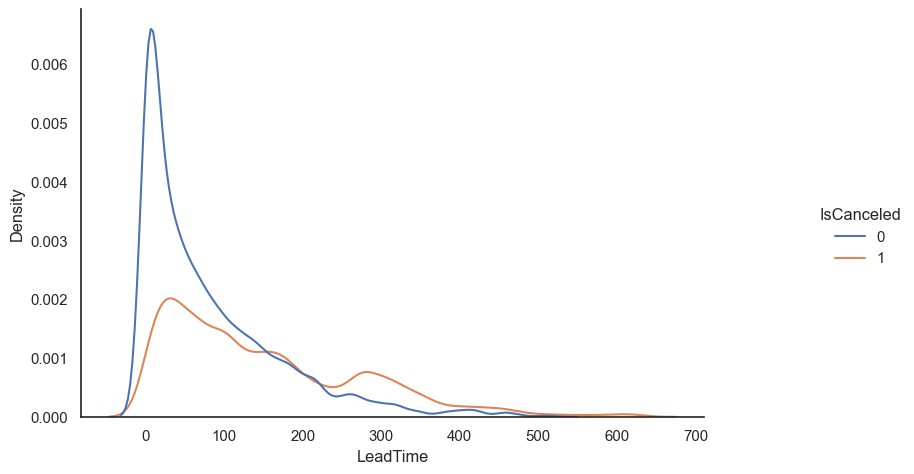

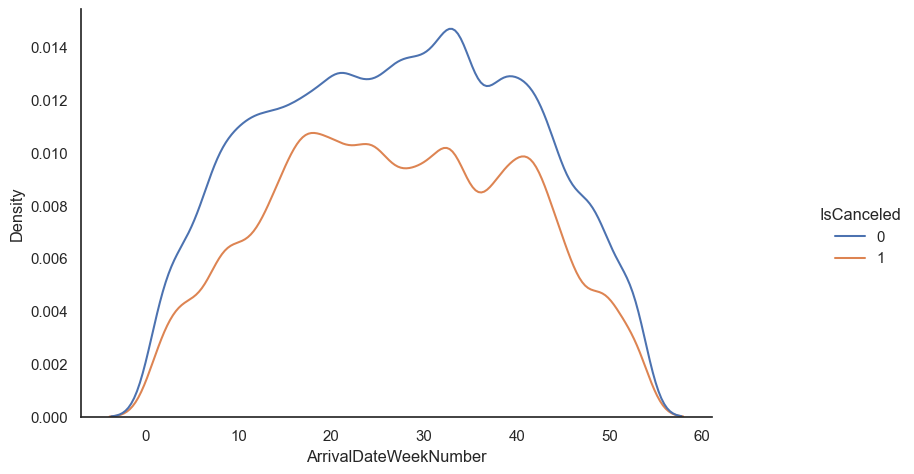

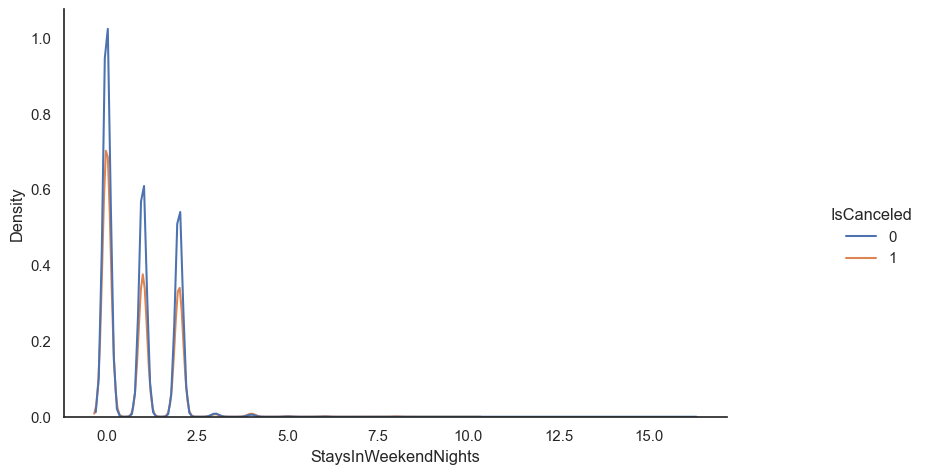

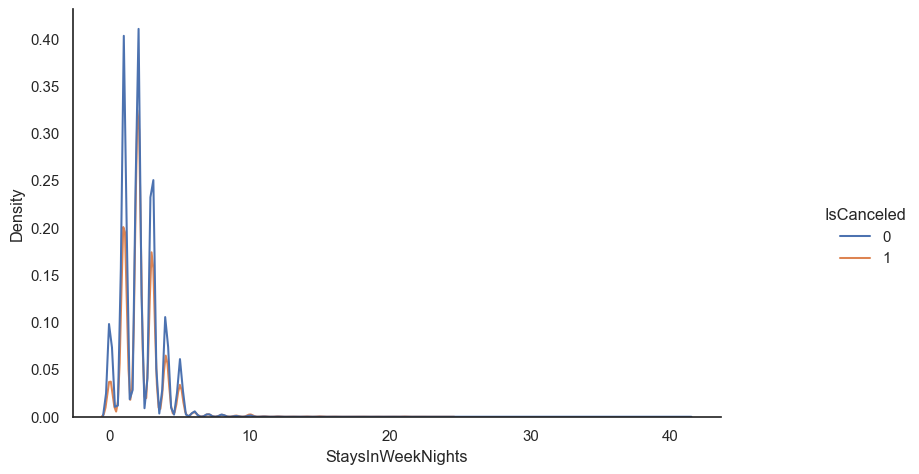

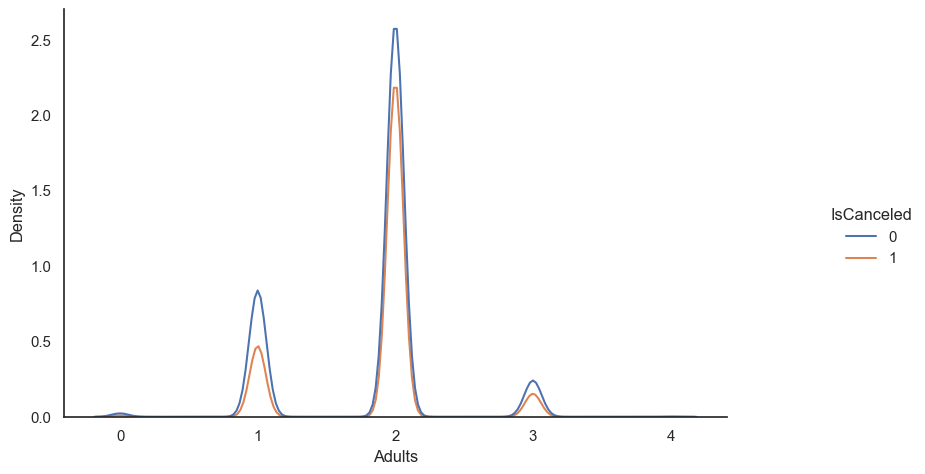

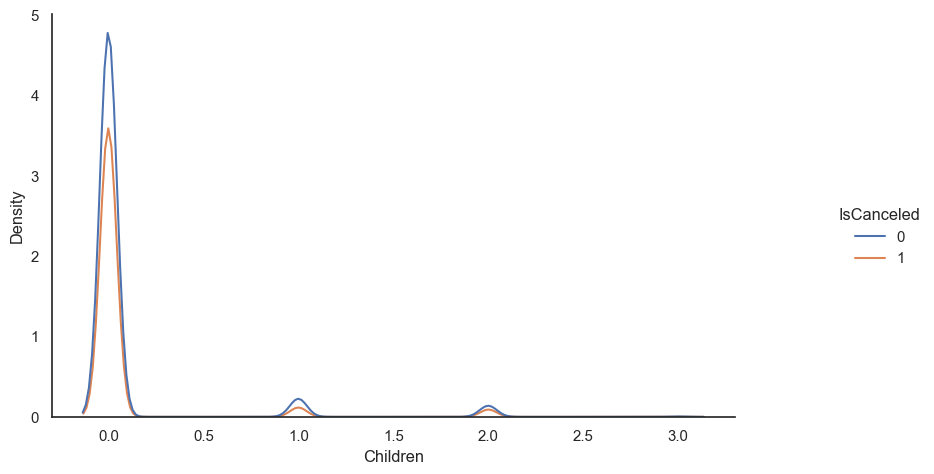

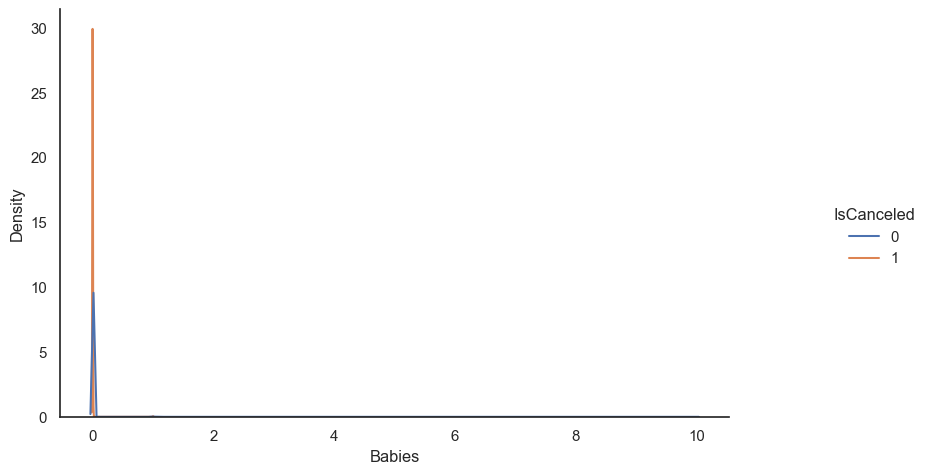

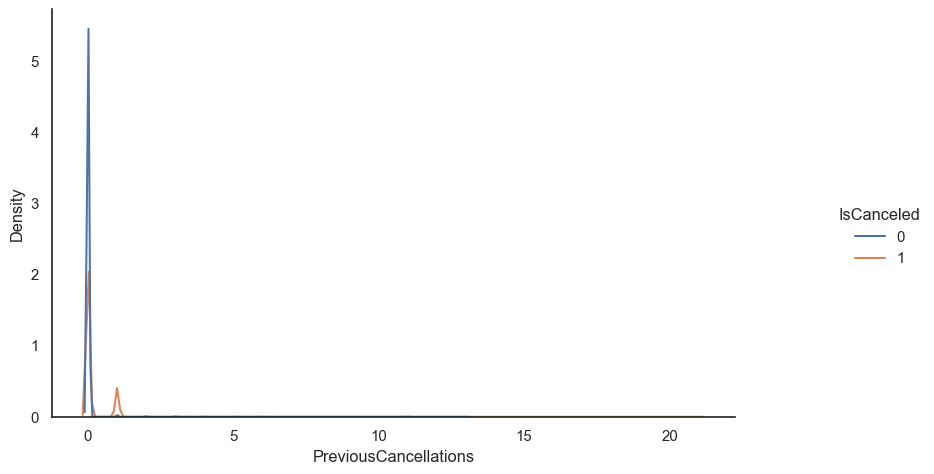

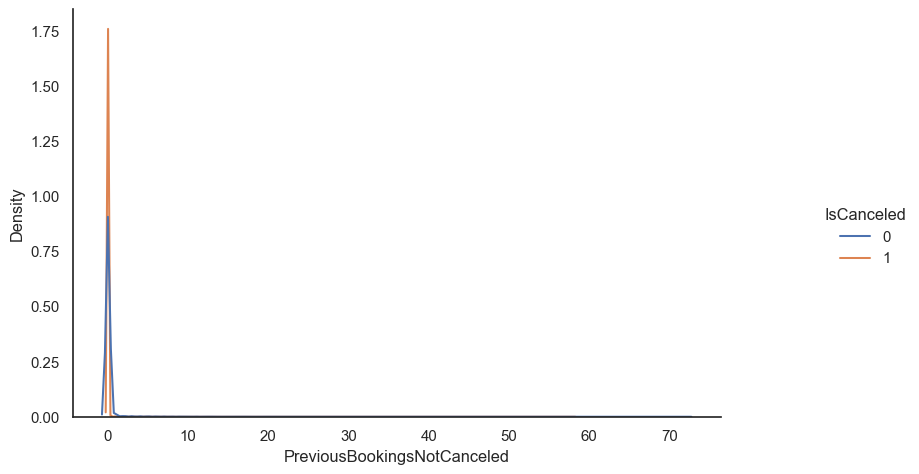

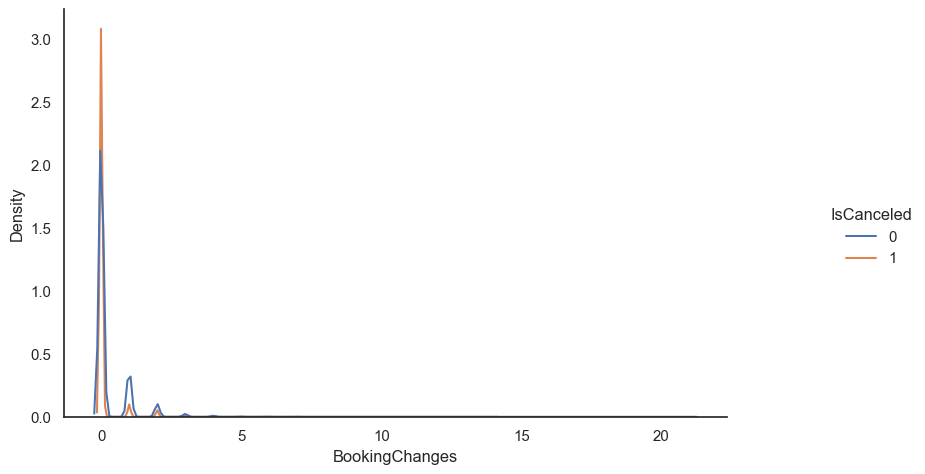

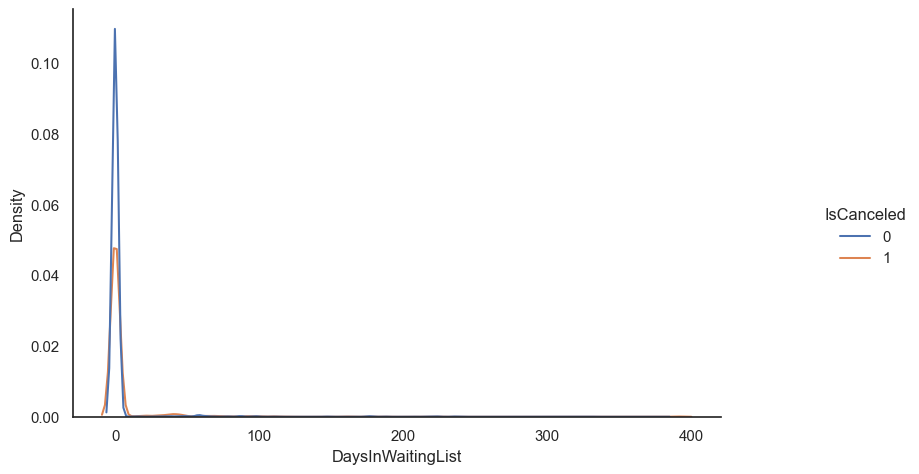

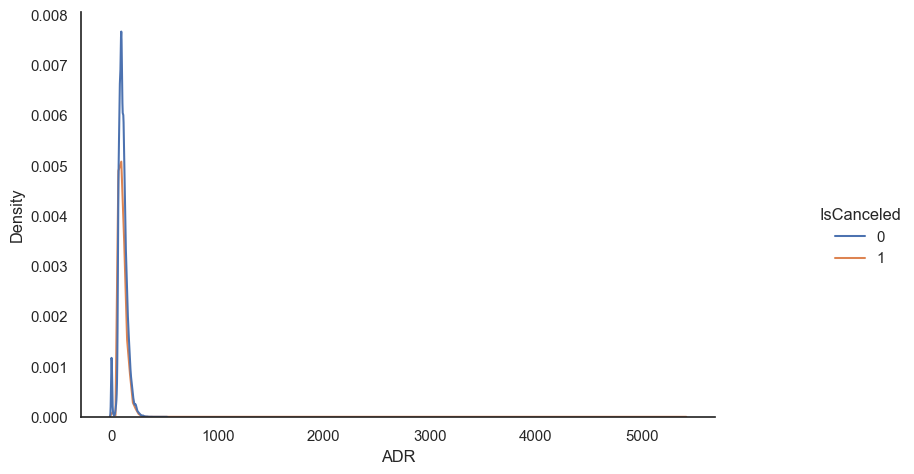

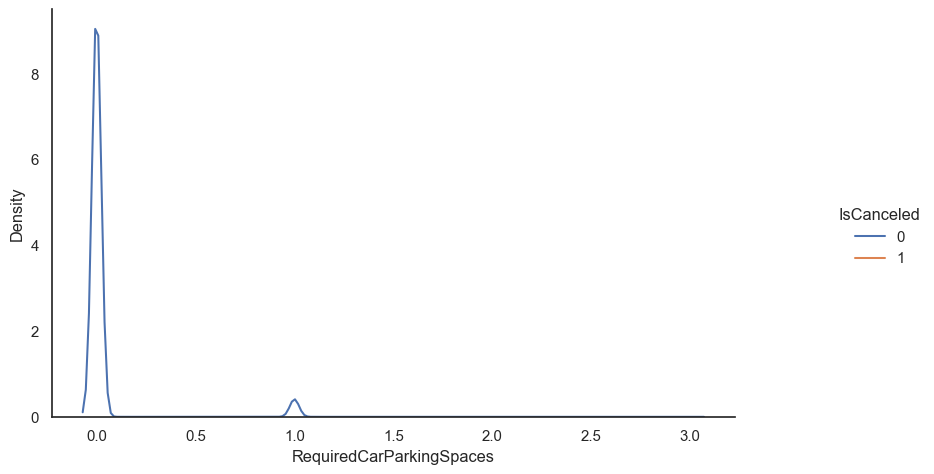

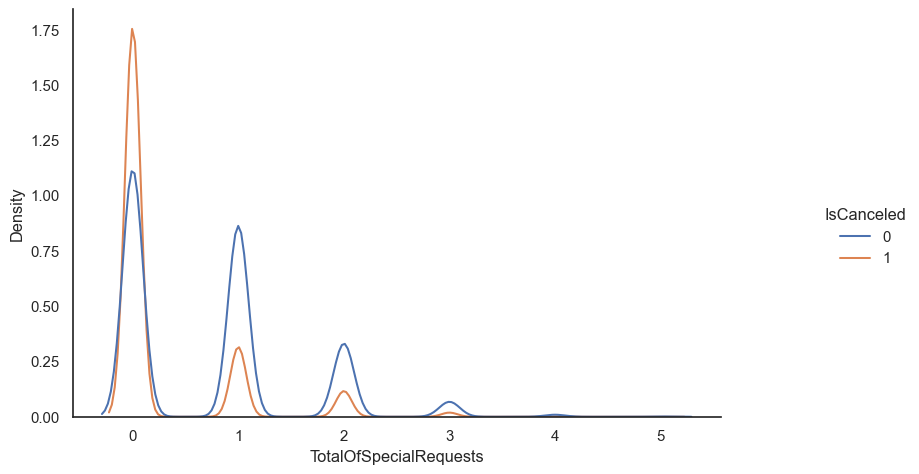

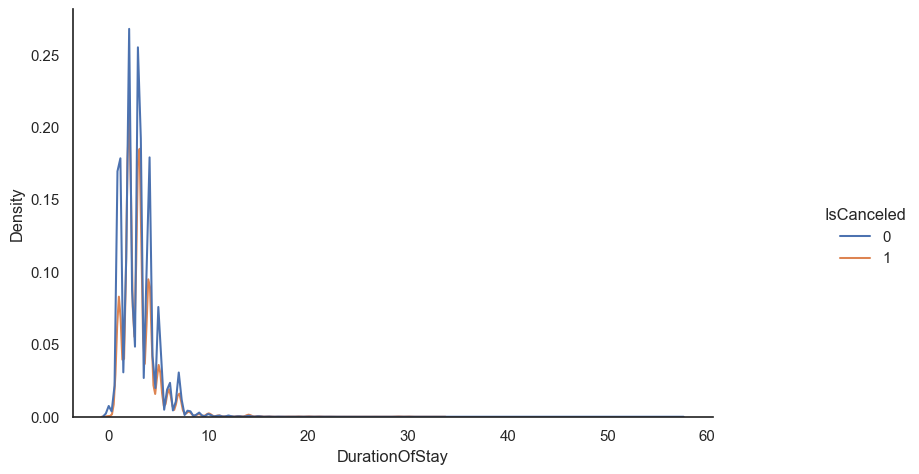

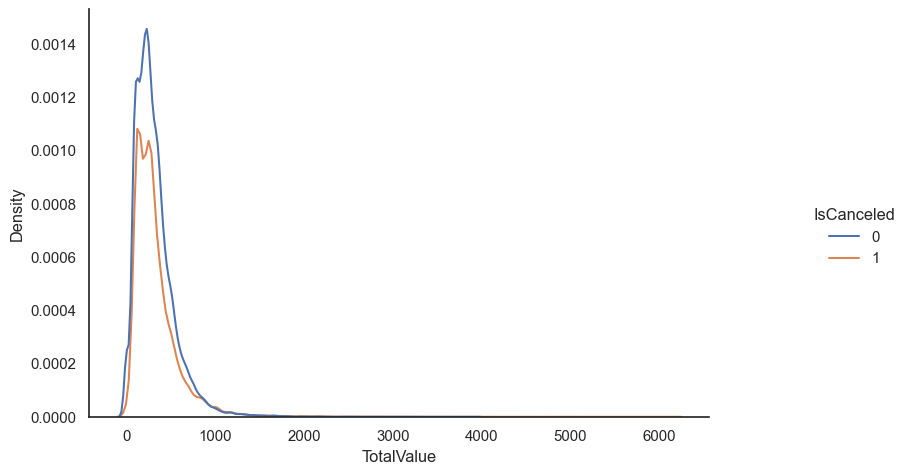

In [192]:
for feature in metric_features:
    g = sns.displot(data=data, x=feature, hue="IsCanceled", kind="kde");
    g.fig.set_size_inches(10,5)

In [193]:
data.groupby("ReservedRoomType")["ADR"].count()

ReservedRoomType
A                   62595
B                    1115
C                      14
D                   11768
E                    1553
F                    1791
G                     484
P                      10
Name: ADR, dtype: int64

In [194]:
data[(data["AssignedRoomType"] == "P               ")]
# data.ReservedRoomType.unique()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek
20591,1,0,2016,47,17,4,11,0,0,0,SC,PRT,Corporate,Direct,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-11-17,15,0.0,11,2016-11-17,3,17,46,11,3
21184,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1
21185,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1
21189,1,0,2016,50,6,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2016-12-06,0,0.0,12,2016-12-06,1,6,49,12,1
25847,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0
25848,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0
25849,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0
25850,1,0,2017,15,10,0,0,0,0,0,SC,PRT,Complementary,Corporate,0,0,0,P,P,0,No Deposit,NULL,279,0,Transient,0.0,0,0,Canceled,2017-04-10,0,0.0,4,2017-04-10,0,10,15,4,0
32907,1,0,2017,32,11,0,0,0,0,0,SC,PRT,Online TA,TA/TO,0,0,0,P,P,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2017-08-11,0,0.0,8,2017-08-11,4,11,32,8,4
32908,1,0,2017,32,11,0,0,0,0,0,SC,PRT,Online TA,TA/TO,0,0,0,P,P,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2017-08-11,0,0.0,8,2017-08-11,4,11,32,8,4


In [195]:
# data.value_counts("ADR")#.iloc[0]
data.loc[data["ADR"] == 0]#.value_counts("ReservationStatus")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate,DurationOfStay,TotalValue,ArrivalDateMonthNumber,ArrivalDate,ArrivalDayOfWeek,ReservationDayOfMonth,ReservationWeekOfYear,ReservationMonth,ReservationDayOfWeek
0,0,6,2015,27,1,0,2,1,0,0,HB,PRT,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,6,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-03,2,0.0,7,2015-07-01,2,3,27,7,4
134,1,0,2015,29,15,0,1,2,0,0,SC,PRT,Direct,Direct,0,0,0,A,F,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Canceled,2015-07-15,1,0.0,7,2015-07-15,2,15,29,7,2
139,0,0,2015,29,15,2,5,2,0,0,SC,PRT,Direct,Direct,0,0,0,F,A,4,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-07-22,7,0.0,7,2015-07-15,2,22,30,7,2
166,0,18,2015,29,18,1,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Check-Out,2015-07-20,2,0.0,7,2015-07-18,5,20,30,7,0
196,0,12,2015,29,18,2,2,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,0,No Deposit,1,NULL,0,Transient-Party,0.0,0,0,Check-Out,2015-07-22,4,0.0,7,2015-07-18,5,22,30,7,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78571,0,78,2017,34,23,0,0,1,0,0,BB,PRT,Offline TA/TO,TA/TO,0,0,0,A,K,7,No Deposit,98,NULL,0,Transient-Party,0.0,0,0,Check-Out,2017-08-23,0,0.0,8,2017-08-23,2,23,34,8,2
78702,0,1,2017,34,24,0,1,2,1,0,BB,PRT,Complementary,Direct,0,0,0,A,D,1,No Deposit,NULL,NULL,0,Transient,0.0,0,3,Check-Out,2017-08-25,1,0.0,8,2017-08-24,3,25,34,8,4
78903,0,1,2017,35,27,0,0,2,0,0,BB,PRT,Direct,Direct,0,0,0,A,A,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2017-08-27,0,0.0,8,2017-08-27,6,27,34,8,6
79042,0,518,2017,34,26,2,1,1,0,0,BB,PRT,Groups,TA/TO,0,0,0,A,A,1,No Deposit,229,NULL,0,Transient-Party,0.0,0,0,Check-Out,2017-08-29,3,0.0,8,2017-08-26,5,29,35,8,1


In [ ]:
data.loc[(data["ArrivalDateYear"] == 2015) &
(data["ArrivalDateMonth"] == "August") & 
(data["ArrivalDateDayOfMonth"] == 2)].sort_values("ADR")

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
534,0,2,2015,August,32,2,1,0,1,0.0,0,BB,AGO,Complementary,Direct,0,0,0,E,D,0,No Deposit,NULL,NULL,0,Transient,0.0,0,0,Check-Out,2015-08-03
36569,0,3,2015,August,32,2,1,0,1,0.0,0,BB,PRT,Complementary,Corporate,0,0,0,A,D,0,No Deposit,NULL,NULL,0,Transient,0.0,0,1,Check-Out,2015-08-03
36582,0,3,2015,August,32,2,1,0,1,0.0,0,BB,PRT,Complementary,TA/TO,0,0,0,A,D,0,No Deposit,NULL,NULL,0,Transient,0.0,0,1,Check-Out,2015-08-03
535,0,83,2015,August,32,2,2,1,2,0.0,0,BB,BEL,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient,76.5,0,1,Check-Out,2015-08-05
36589,0,150,2015,August,32,2,2,0,2,0.0,0,BB,BEL,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient-Party,76.5,0,1,Check-Out,2015-08-04
36590,0,150,2015,August,32,2,2,0,2,0.0,0,BB,BEL,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,9,NULL,0,Transient-Party,76.5,0,1,Check-Out,2015-08-04


In [ ]:
data.loc[(data["ADR"] == 0) & (data["MarketSegment"] != "Complementary")]
data.loc[(data["ADR"] == 0)].value_counts("MarketSegment")

MarketSegment
Complementary    508
Offline TA/TO    236
Online TA        173
Groups           144
Direct           111
Corporate         30
Aviation           6
dtype: int64

In [ ]:
data.loc[data["MarketSegment"] == "Complementary"].sort_values("ADR", ascending = False)

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,Meal,Country,MarketSegment,DistributionChannel,IsRepeatedGuest,PreviousCancellations,PreviousBookingsNotCanceled,ReservedRoomType,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
37755,0,0,2015,September,39,26,1,1,1,0.0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,1,No Deposit,NULL,NULL,0,Transient,170.0,0,0,Check-Out,2015-09-28
45705,0,0,2016,March,13,20,1,0,2,0.0,0,BB,DEU,Complementary,TA/TO,0,0,0,A,E,0,No Deposit,NULL,NULL,0,Transient,139.0,0,0,Check-Out,2016-03-21
40489,1,8,2017,March,11,15,0,1,1,0.0,0,BB,PRT,Complementary,Direct,1,1,1,A,A,0,No Deposit,NULL,46,0,Transient,79.0,0,0,Canceled,2017-03-07
40071,0,2,2015,November,46,9,1,2,1,0.0,0,BB,USA,Complementary,Direct,0,0,0,A,A,0,No Deposit,45,NULL,0,Group,79.0,0,0,Check-Out,2015-11-12
61678,0,32,2016,November,47,15,0,2,2,0.0,0,BB,DEU,Complementary,Direct,0,0,0,E,E,0,No Deposit,NULL,NULL,0,Transient,75.0,0,1,Check-Out,2016-11-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38583,1,1,2015,October,42,13,0,1,1,0.0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,NULL,0,Transient,0.0,0,1,Canceled,2015-10-13
38192,0,0,2016,April,17,21,0,1,1,0.0,0,BB,PRT,Complementary,Direct,1,0,1,G,G,0,No Deposit,NULL,45,0,Transient,0.0,0,0,Check-Out,2016-04-22
38191,0,8,2015,October,41,6,0,1,1,0.0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,45,0,Transient,0.0,0,0,Check-Out,2015-10-07
38149,1,8,2015,October,41,6,0,1,1,0.0,0,BB,PRT,Complementary,Direct,0,0,0,A,A,0,No Deposit,NULL,45,0,Transient,0.0,0,0,No-Show,2015-10-06


In [ ]:
data.value_counts("MarketSegment")

MarketSegment
Online TA        38748
Offline TA/TO    16747
Groups           13975
Direct            6093
Corporate         2986
Complementary      542
Aviation           237
Undefined            2
dtype: int64

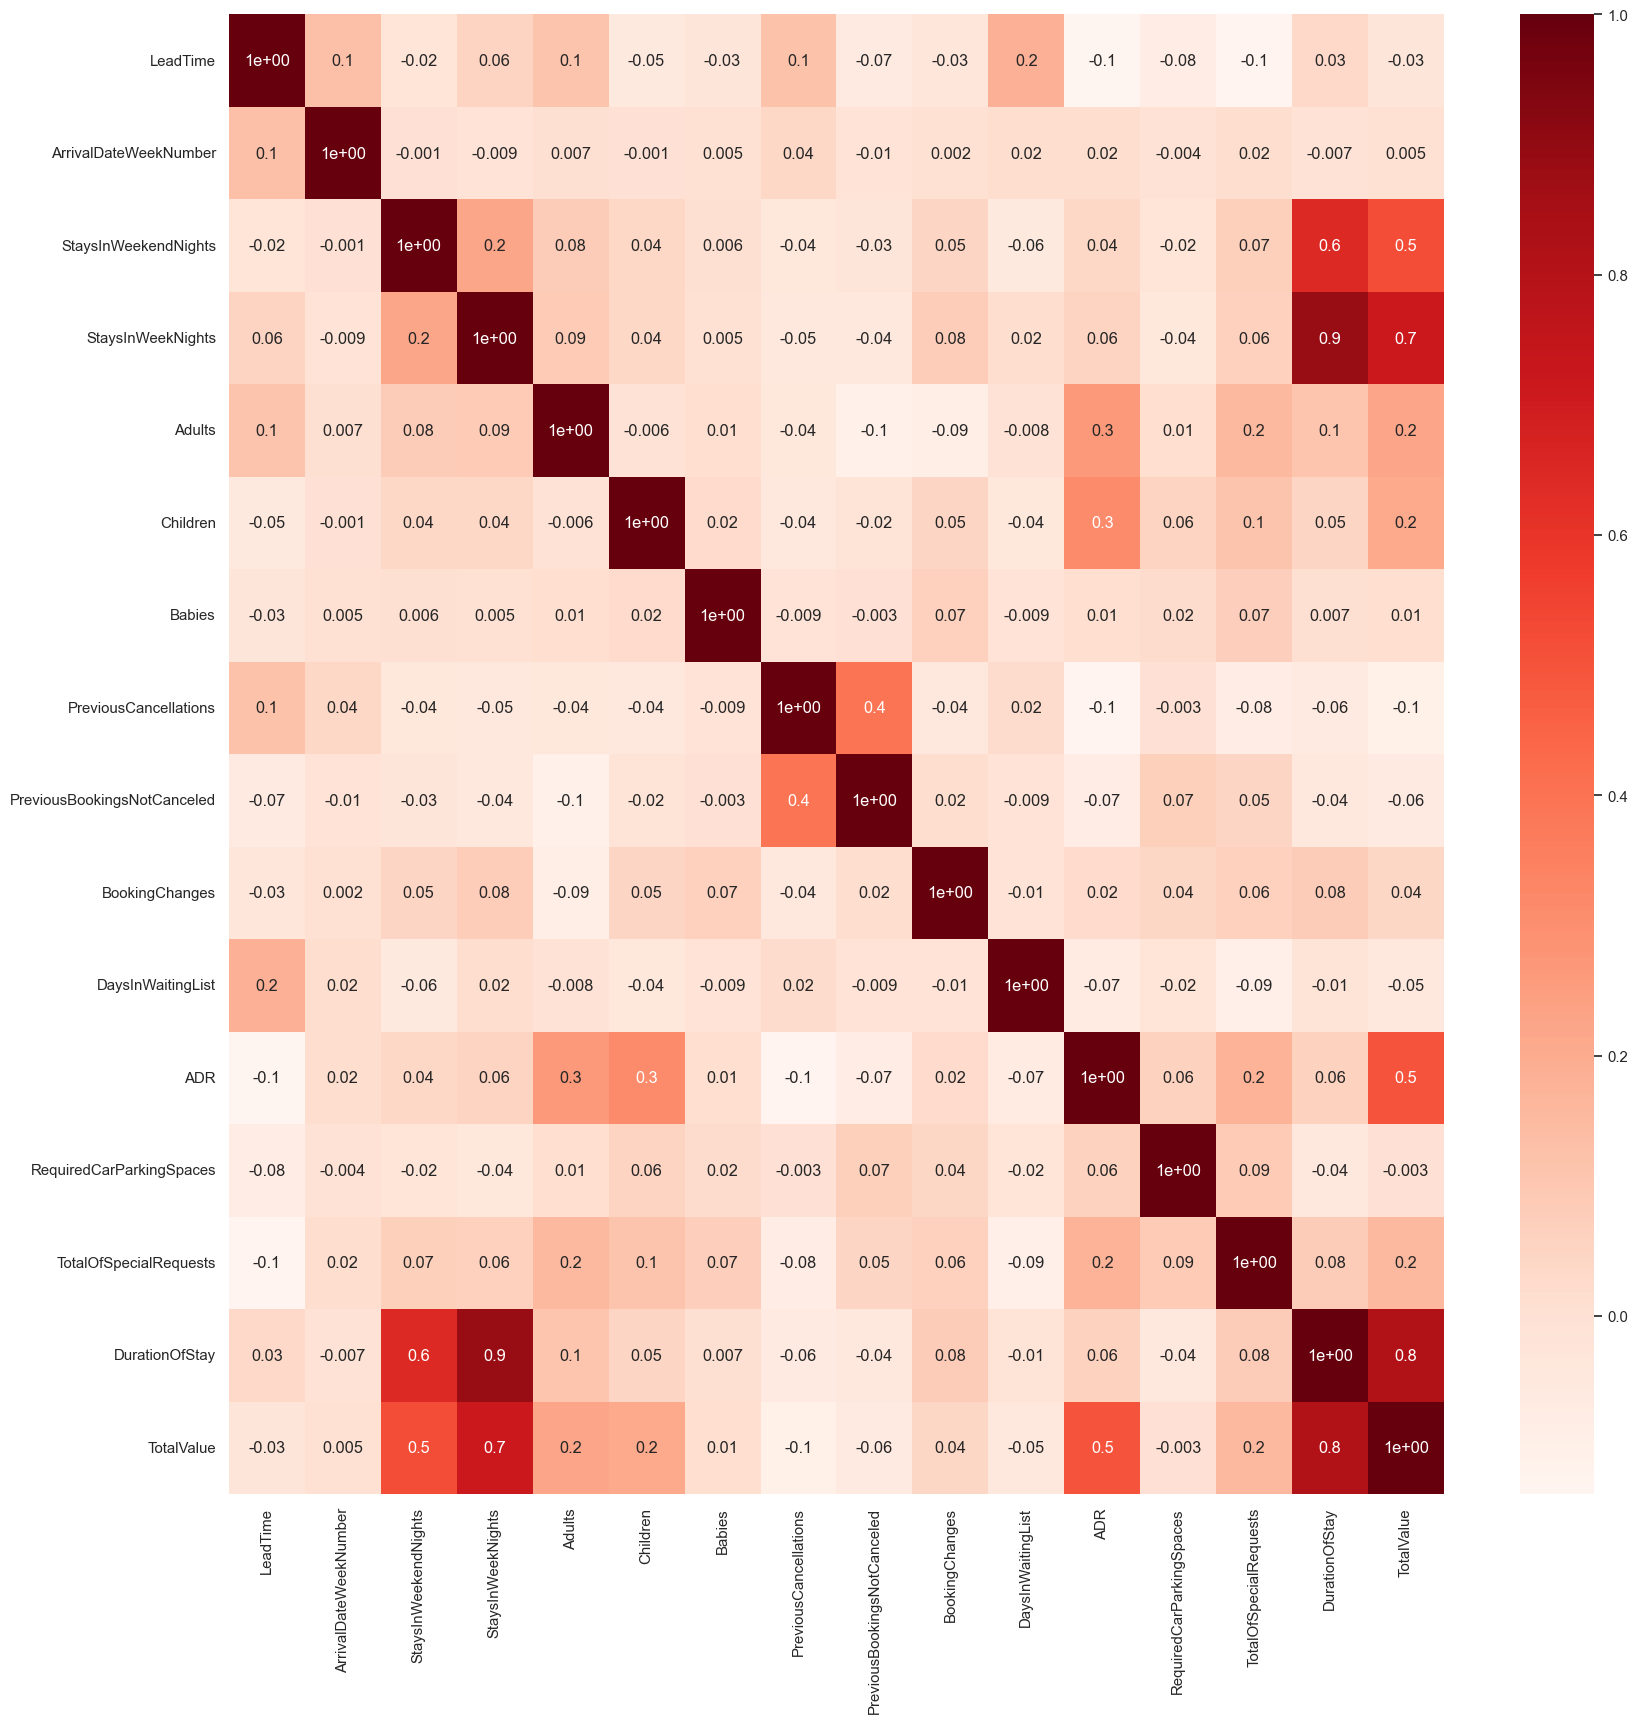

In [206]:
def cor_heatmap(cor):
    plt.figure(figsize=(20,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()
    
cor_heatmap(np.round(data[metric_features].corr(),3))

## OUTLIERS TREATEMENT AND DATA TRANSFORMATION

In [235]:
data_out = data.copy()
data_out1 = data.copy()

In [221]:
# #TODO find methods for multi dimensional outliers
# def Isolation_Forest (data):
   
    
#     #this algorithm only works with data without missing values
#     data_out = data[numeric_features]
#     #data_out = data.select_dtypes(include=np.number).set_index(data.index)
#     forest_model = IsolationForest(n_estimators=20,contamination=0.01)
#     forest_model.fit(data_out)
#     anomally = forest_model.decision_function(data_out)
#     predict_outcome = forest_model.predict(data_out)
    
#     #creating a dataset with the density scores and the predicted outcome (-1==outlier; 1==normal obs)
#     data_out_score = pd.DataFrame(data=anomally, index=data_out.index)
#     data_out_score['predicted_outcome'] = predict_outcome
#     return(data_out_score)

# def Isolation_Forest_test (data):
#     outliers = Isolation_Forest(data)
#     outliers_test = pd.DataFrame(index = data.index)
#     outliers_test['predicted_outcome'] = outliers['predicted_outcome']
#     outliers_test.loc[outliers_test['predicted_outcome']==1, 'predicted_outcome']= 0 
#     outliers_test.loc[outliers_test['predicted_outcome']==-1, 'predicted_outcome']= 1
#     return(outliers_test)

# #data_IF = Isolation_Forest(data_outliers)
# data_IF = Isolation_Forest_test(data_out)

In [224]:
# data_out["Outlier"] = data_IF["predicted_outcome"]

In [227]:
# for i in data_out.loc[:, data.select_dtypes(include=np.number).columns].columns:
#     col = np.array(data.columns)
#     col = col[col!=i]
#     for index , ii in enumerate(col):
#         plt.figure(index)
#         sns.scatterplot(data_out[i],data_out[ii],hue=data_out['Outlier'])
#         plt.show()

In [240]:
ee = OneClassSVM(nu=0.03)
yhat = ee.fit_predict(data_out[numeric_features])
yhat1 = ee.fit_predict(data_out[metric_features])

In [241]:
data_out['Outliers'] = yhat
data_out1['Outliers'] = yhat1
data_out_rem= data_out[data_out['Outliers']==1]
data_out_rem1= data_out1[data_out1['Outliers']==1]

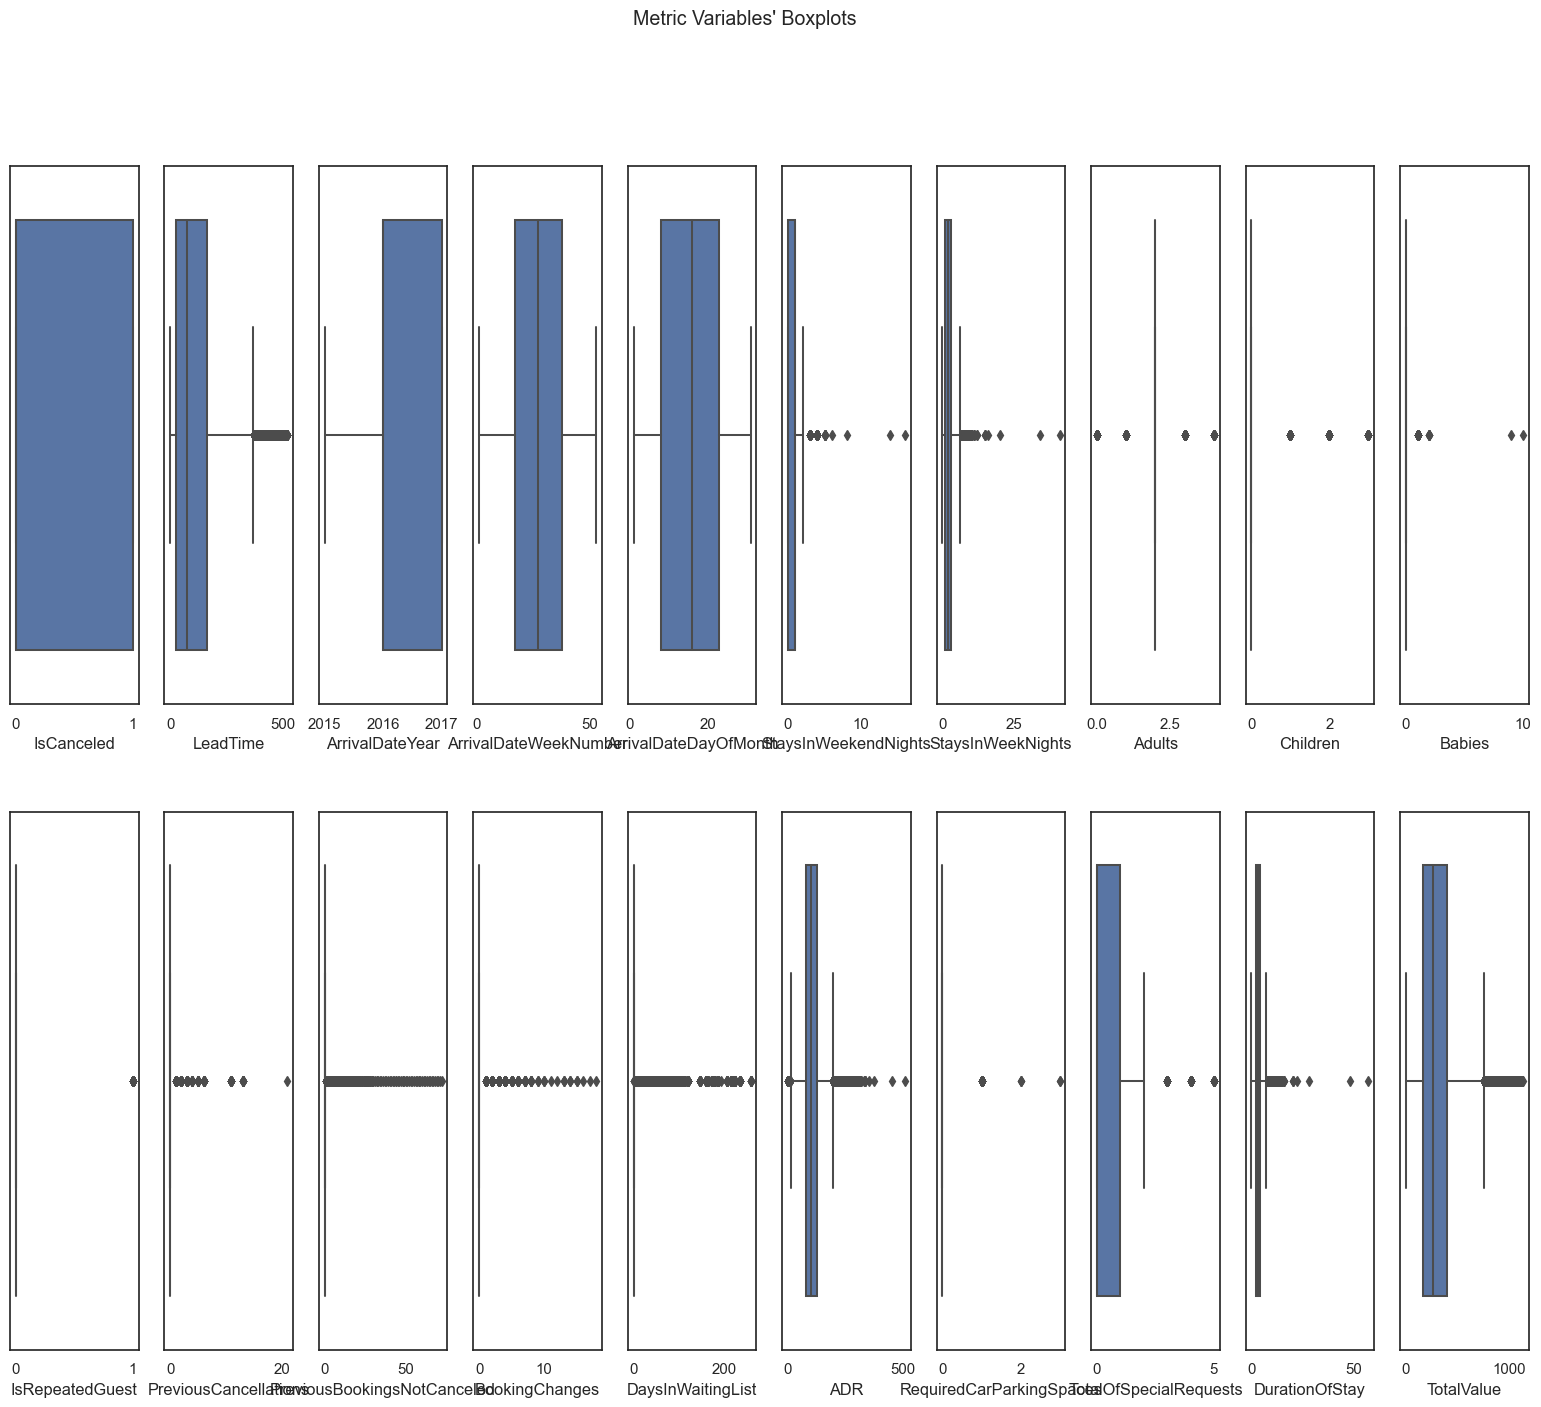

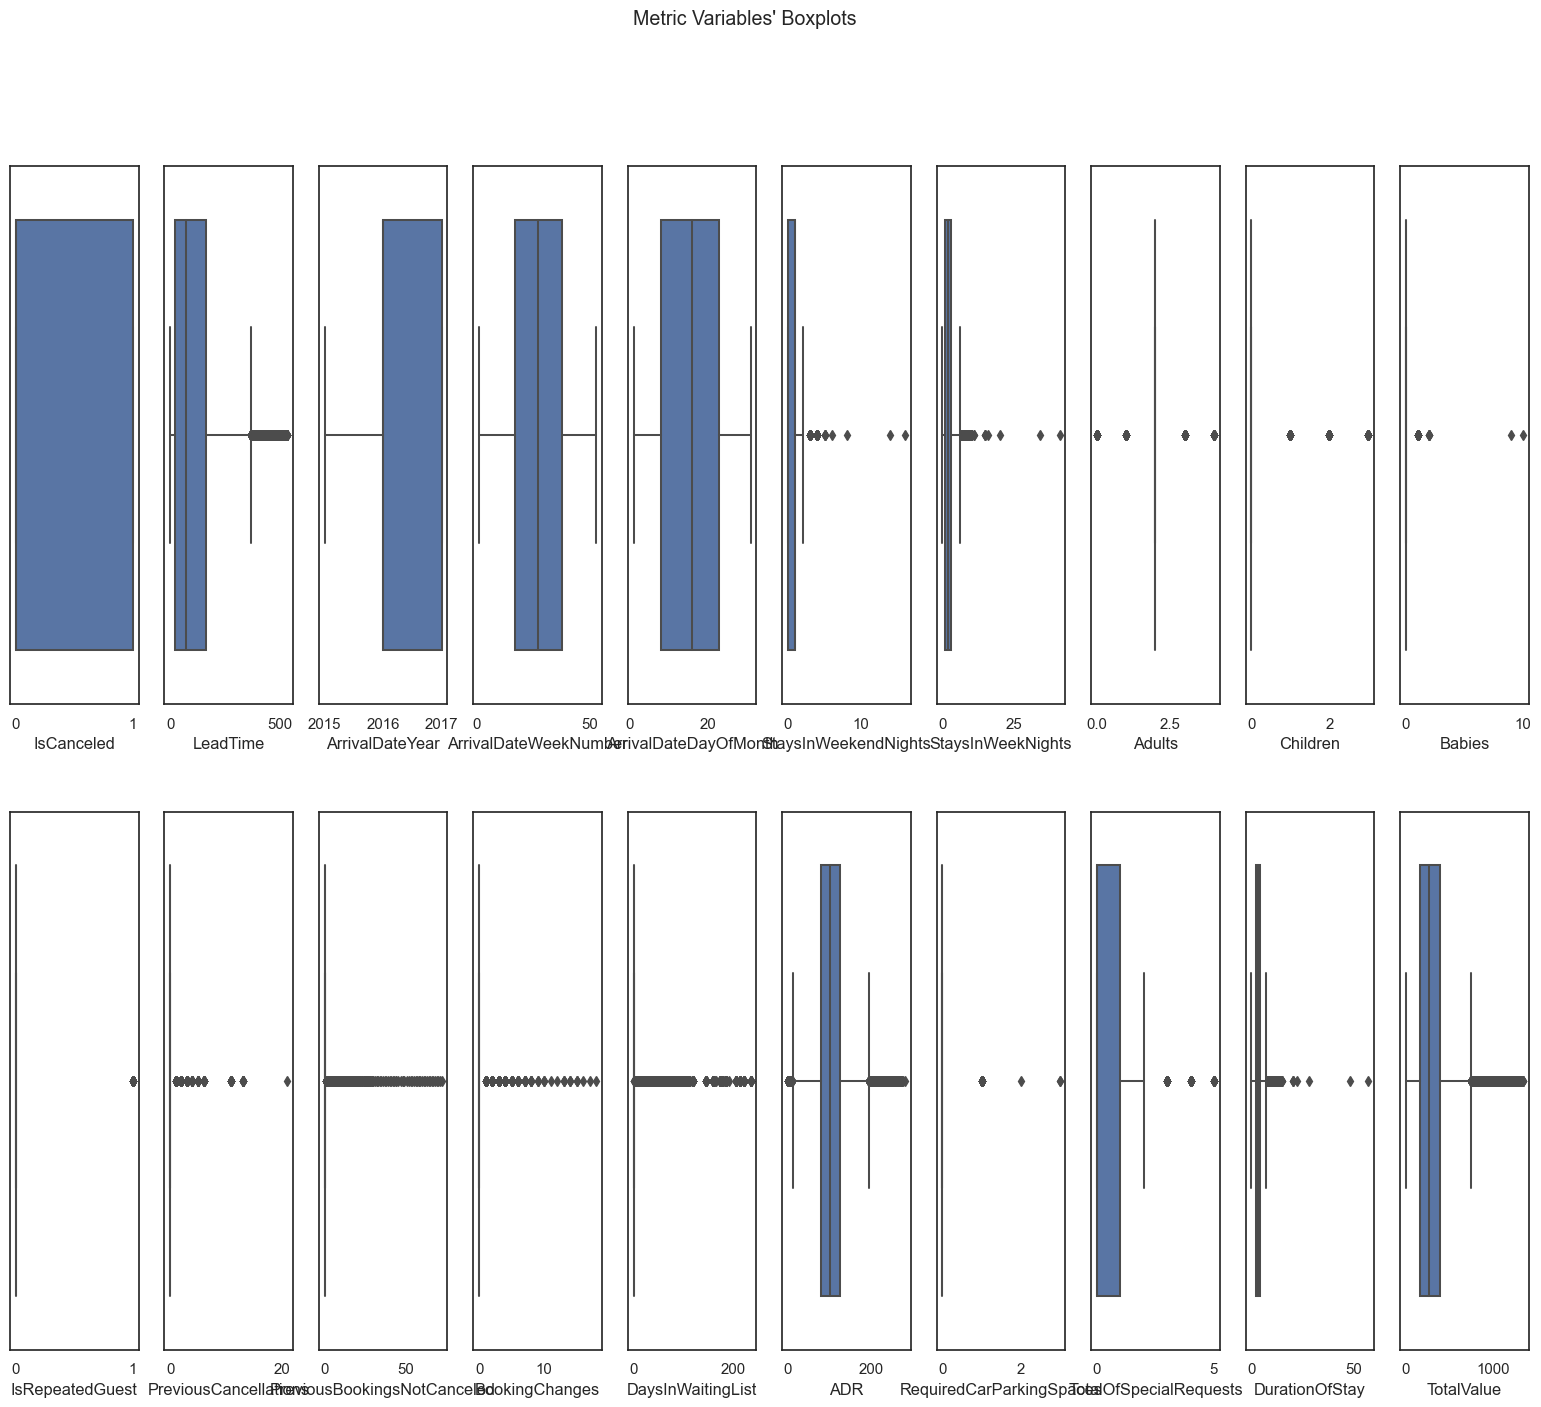

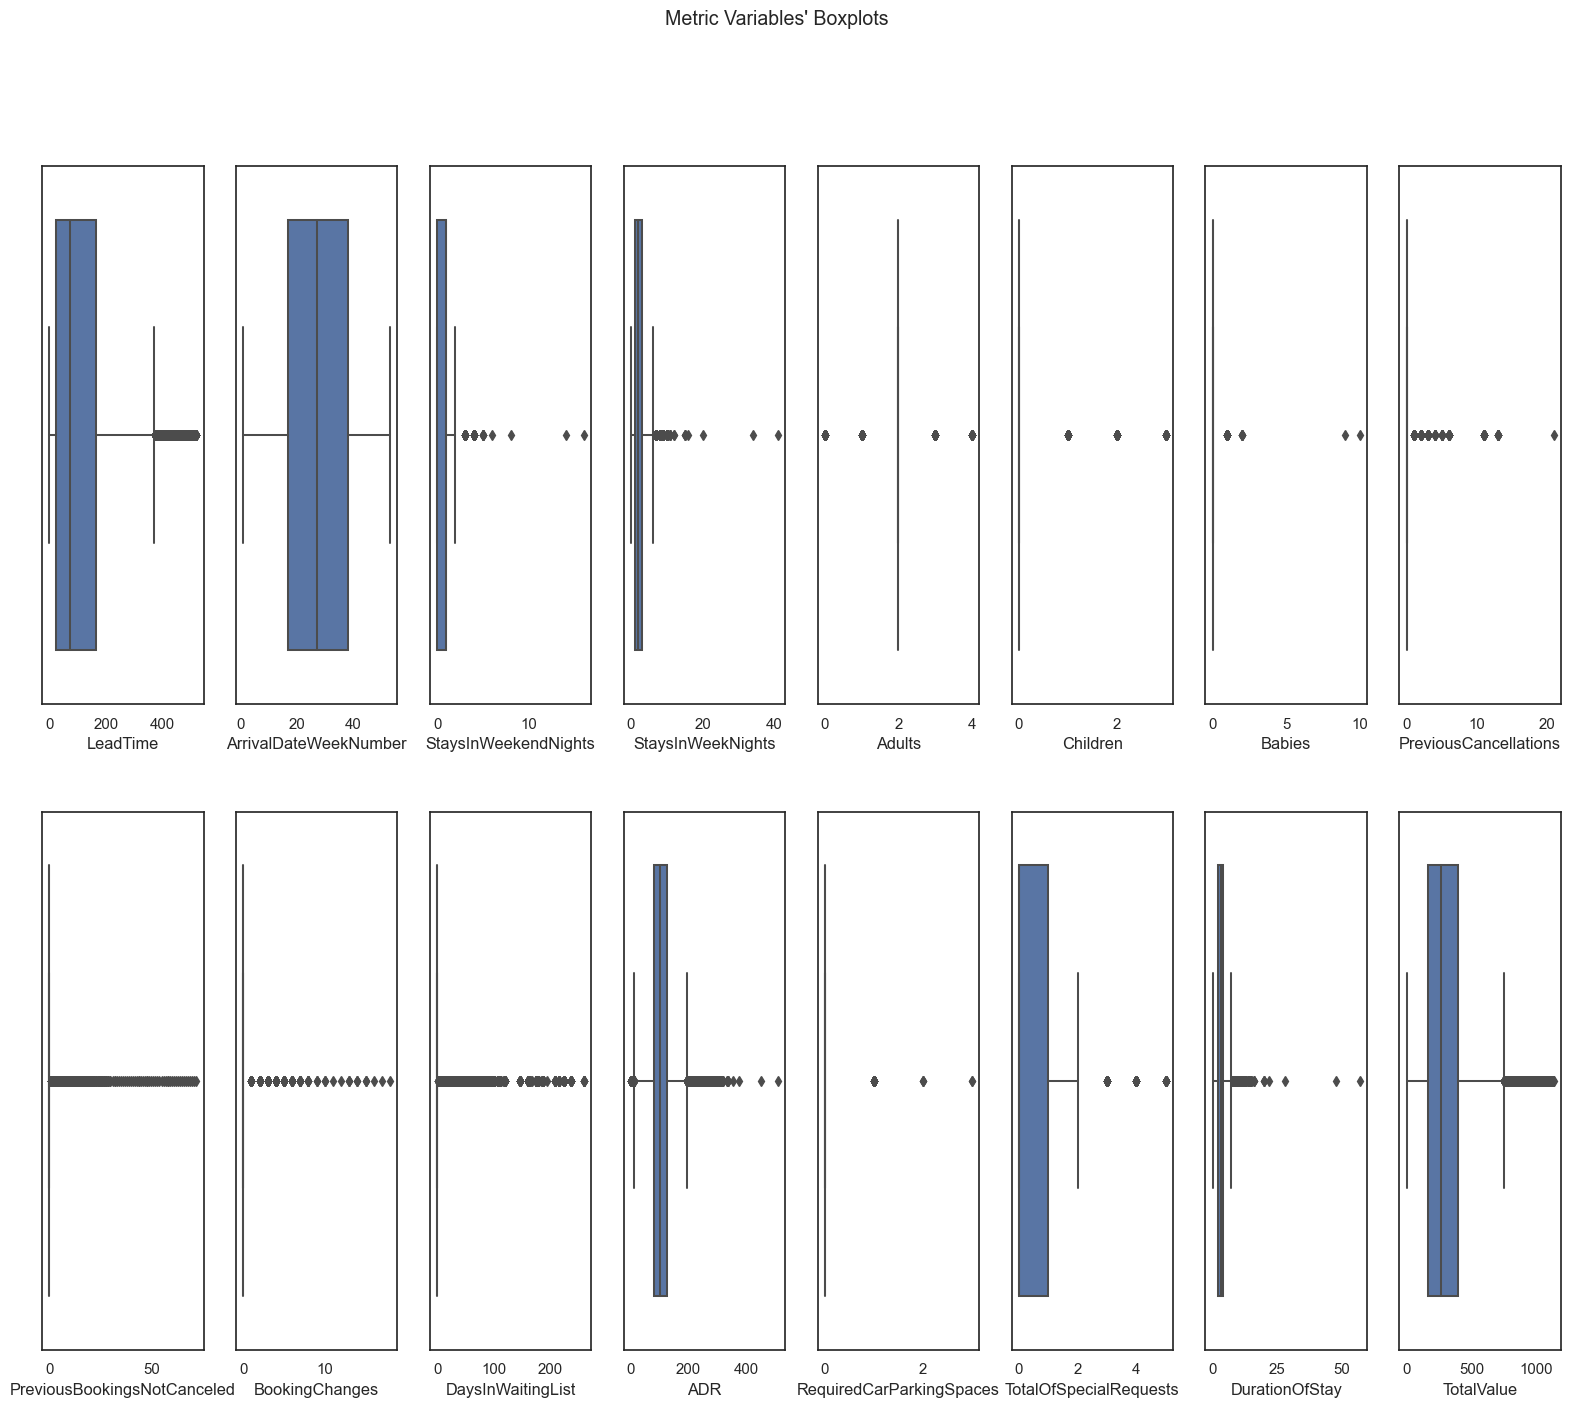

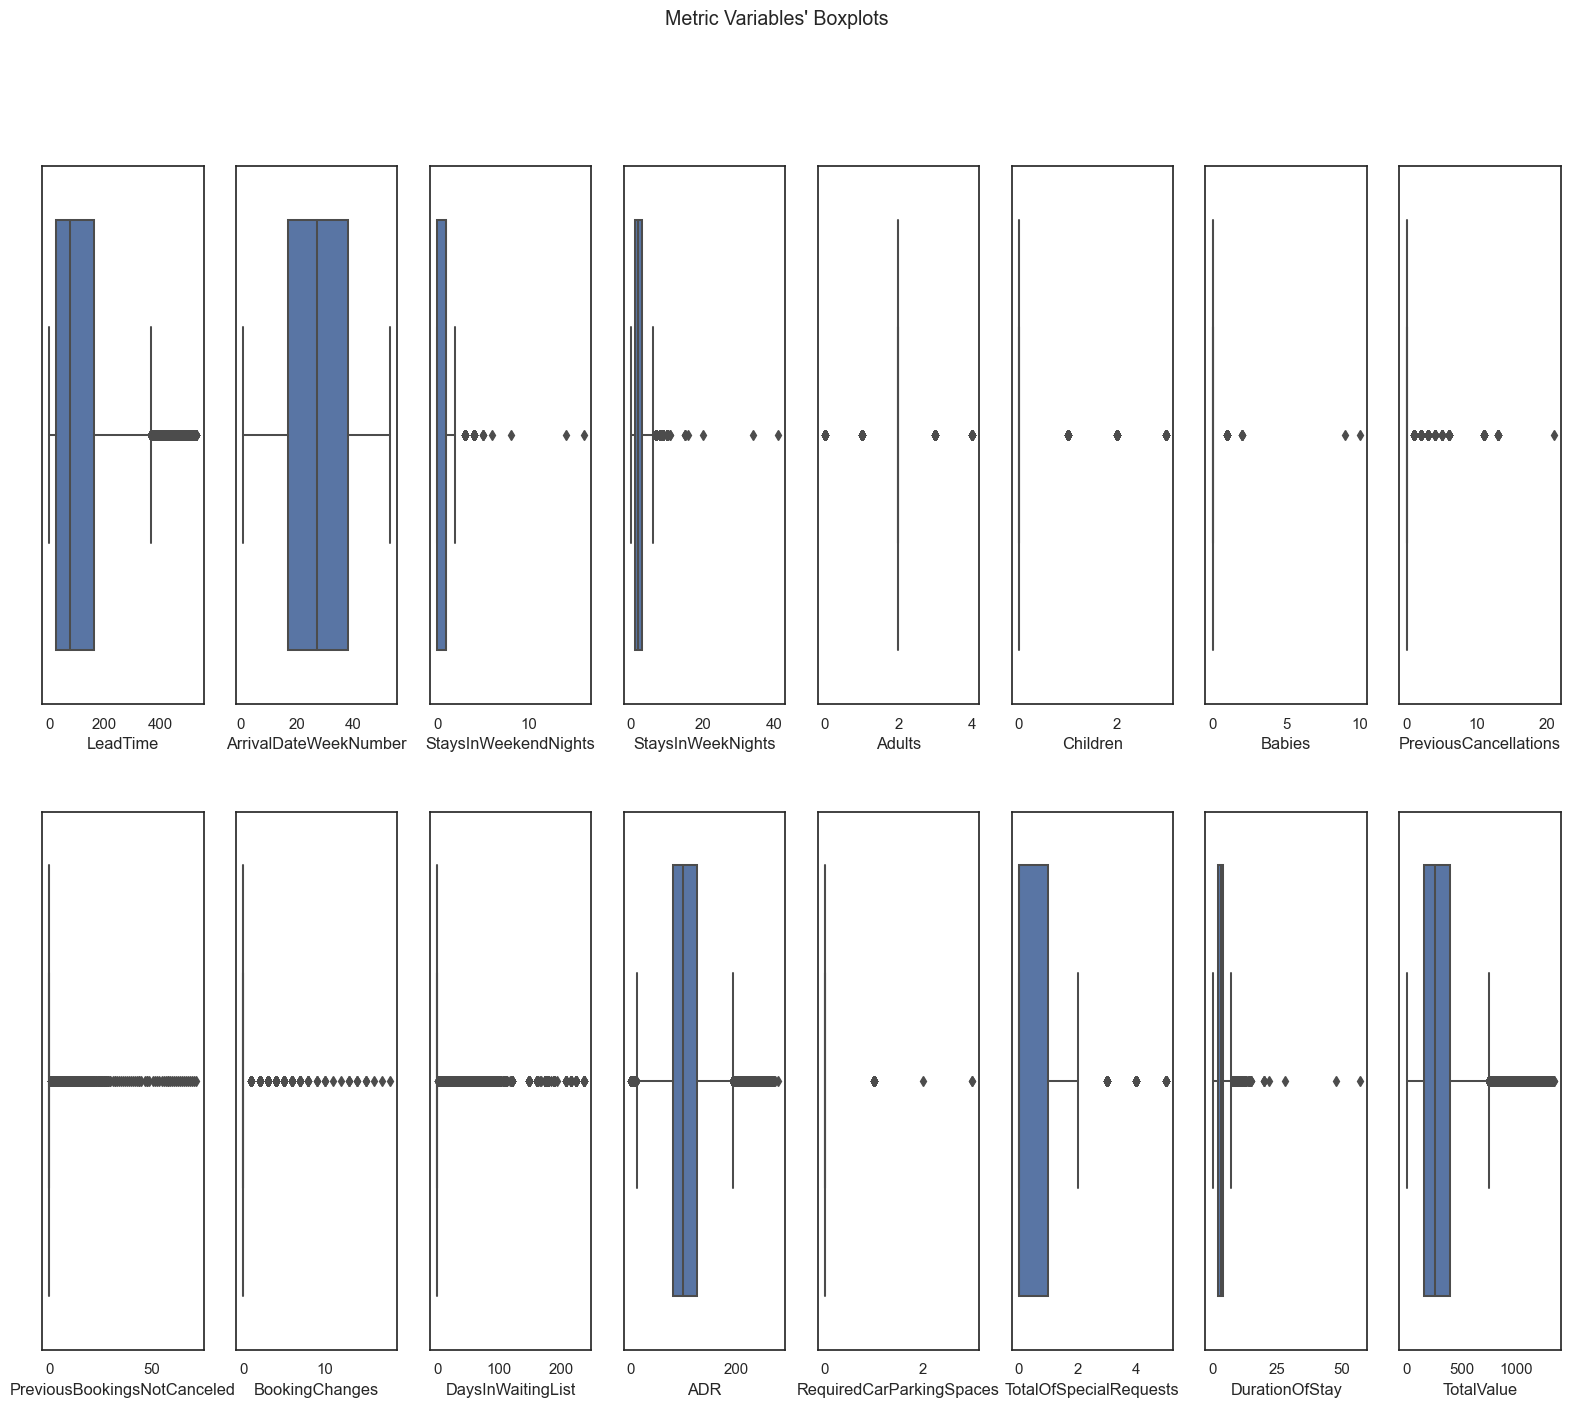

In [242]:
boxplot(data_out_rem, numeric_features)
boxplot(data_out_rem1, numeric_features)
boxplot(data_out_rem, metric_features)
boxplot(data_out_rem1, metric_features)